In [10]:
pip install tabulate

Note: you may need to restart the kernel to use updated packages.


In [11]:
pip install wandb

Note: you may need to restart the kernel to use updated packages.


In [12]:
# Cell 1: Setup
import sys
from pathlib import Path
sys.path.append('..')

import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import numpy as np
import pandas as pd
from tabulate import tabulate
from PIL import Image
from tqdm import tqdm  # Add this import
from datetime import datetime  # Add this too
import torch
import yaml
import os
import random
from src.utils.visualizer import YOLOVisualizer

# Set high DPI for academic quality figures
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'sans-serif'
sns.set_style("whitegrid")

from src.evaluation.evaluator import ComprehensiveEvaluator

In [13]:
# Cell: Force Reload Evaluator Module
import importlib
import sys

# Remove the cached module
if 'src.evaluation.evaluator' in sys.modules:
    del sys.modules['src.evaluation.evaluator']

In [14]:
# Set reproducibility

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")


PyTorch: 2.8.0
CUDA available: False


In [15]:
# Cell 2: Configuration
from configs.baseline_config import ExperimentConfig

# Configure your experiment here
config = ExperimentConfig(
    dataset='d3',        # Change to 'd2' or 'd3' as needed
    task='binary',       # Change to 'species' or 'staging' as needed
    model_name='yolo11s',
    epochs=10           # Increase to 200 for full training
)

experiment_name = config.get_experiment_name()
print(f"Experiment: {experiment_name}")
print(f"Dataset: {config.dataset.upper()}")
print(f"Task: {config.task}")
print(f"Model: {config.model_name}")

Experiment: yolo11s_d3_binary_baseline
Dataset: D3
Task: binary
Model: yolo11s


In [ ]:
# Diagnostic Cell 

# Check actual structure
base = Path("/Users/thabangisaka/Downloads/thabang_phd/Experiments/Year 3 Experiments/malaria_experiments")
d1_path = base / "dataset_d1"

print("Checking D1 structure:")
print(f"D1 exists: {d1_path.exists()}")

if d1_path.exists():
    # List top level
    print("\nTop level contents:")
    for item in sorted(d1_path.iterdir()):
        if item.is_dir():
            print(f"  📁 {item.name}/")
            # List subdirectories
            for subitem in sorted(item.iterdir())[:5]:  # Show first 5
                if subitem.is_dir():
                    print(f"      📁 {subitem.name}/")
                else:
                    print(f"      📄 {subitem.name}")
            if len(list(item.iterdir())) > 5:
                print(f"      ... and {len(list(item.iterdir())) - 5} more items")

In [16]:
# Cell 3: Prepare Dataset (Handles conversion automatically)
from src.utils.paths import get_dataset_paths, verify_dataset

# This will automatically convert COCO to YOLO if needed
dataset_valid = verify_dataset(config.dataset, config.task)
if not dataset_valid:
    raise RuntimeError(f"Dataset preparation failed for {config.dataset}/{config.task}")

# Get the YOLO format path
yolo_path = get_dataset_paths(config.dataset, config.task)

# Cell 4: Create YAML for YOLO
yaml_dir = Path('../configs/data_yamls')
yaml_dir.mkdir(exist_ok=True)
yaml_path = yaml_dir / f'{config.dataset}_{config.task}.yaml'

# Simple YAML pointing to YOLO structure
data_yaml = {
    'path': str(yolo_path),  # Points to yolo_format/task/
    'train': 'train/images',
    'val': 'val/images',
    'test': 'test/images',
    'names': config.get_class_names(),
    'nc': len(config.get_class_names())
}

with open(yaml_path, 'w') as f:
    yaml.dump(data_yaml, f, default_flow_style=False)

print(f"Created YAML: {yaml_path}")
print("\nYAML content:")
print(yaml.dump(data_yaml, default_flow_style=False))

YOLO format already exists for d3/binary

Dataset: D3 - Task: binary
YOLO Path: /Users/thabangisaka/Downloads/thabang_phd/Experiments/Year 3 Experiments/malaria_experiments/dataset_d3/yolo_format/binary
--------------------------------------------------
✅ train/images: 20830 files
✅ train/labels: 20514 files
✅ val/images: 3890 files
✅ val/labels: 3890 files
✅ test/images: 4508 files
✅ test/labels: 4501 files

Total: 29228 images, 28905 labels
YOLO format already exists for d3/binary
Created YAML: ../configs/data_yamls/d3_binary.yaml

YAML content:
names:
  0: Uninfected
  1: Infected
nc: 2
path: /Users/thabangisaka/Downloads/thabang_phd/Experiments/Year 3 Experiments/malaria_experiments/dataset_d3/yolo_format/binary
test: test/images
train: train/images
val: val/images



DATASET VISUALIZATION: D3 - BINARY


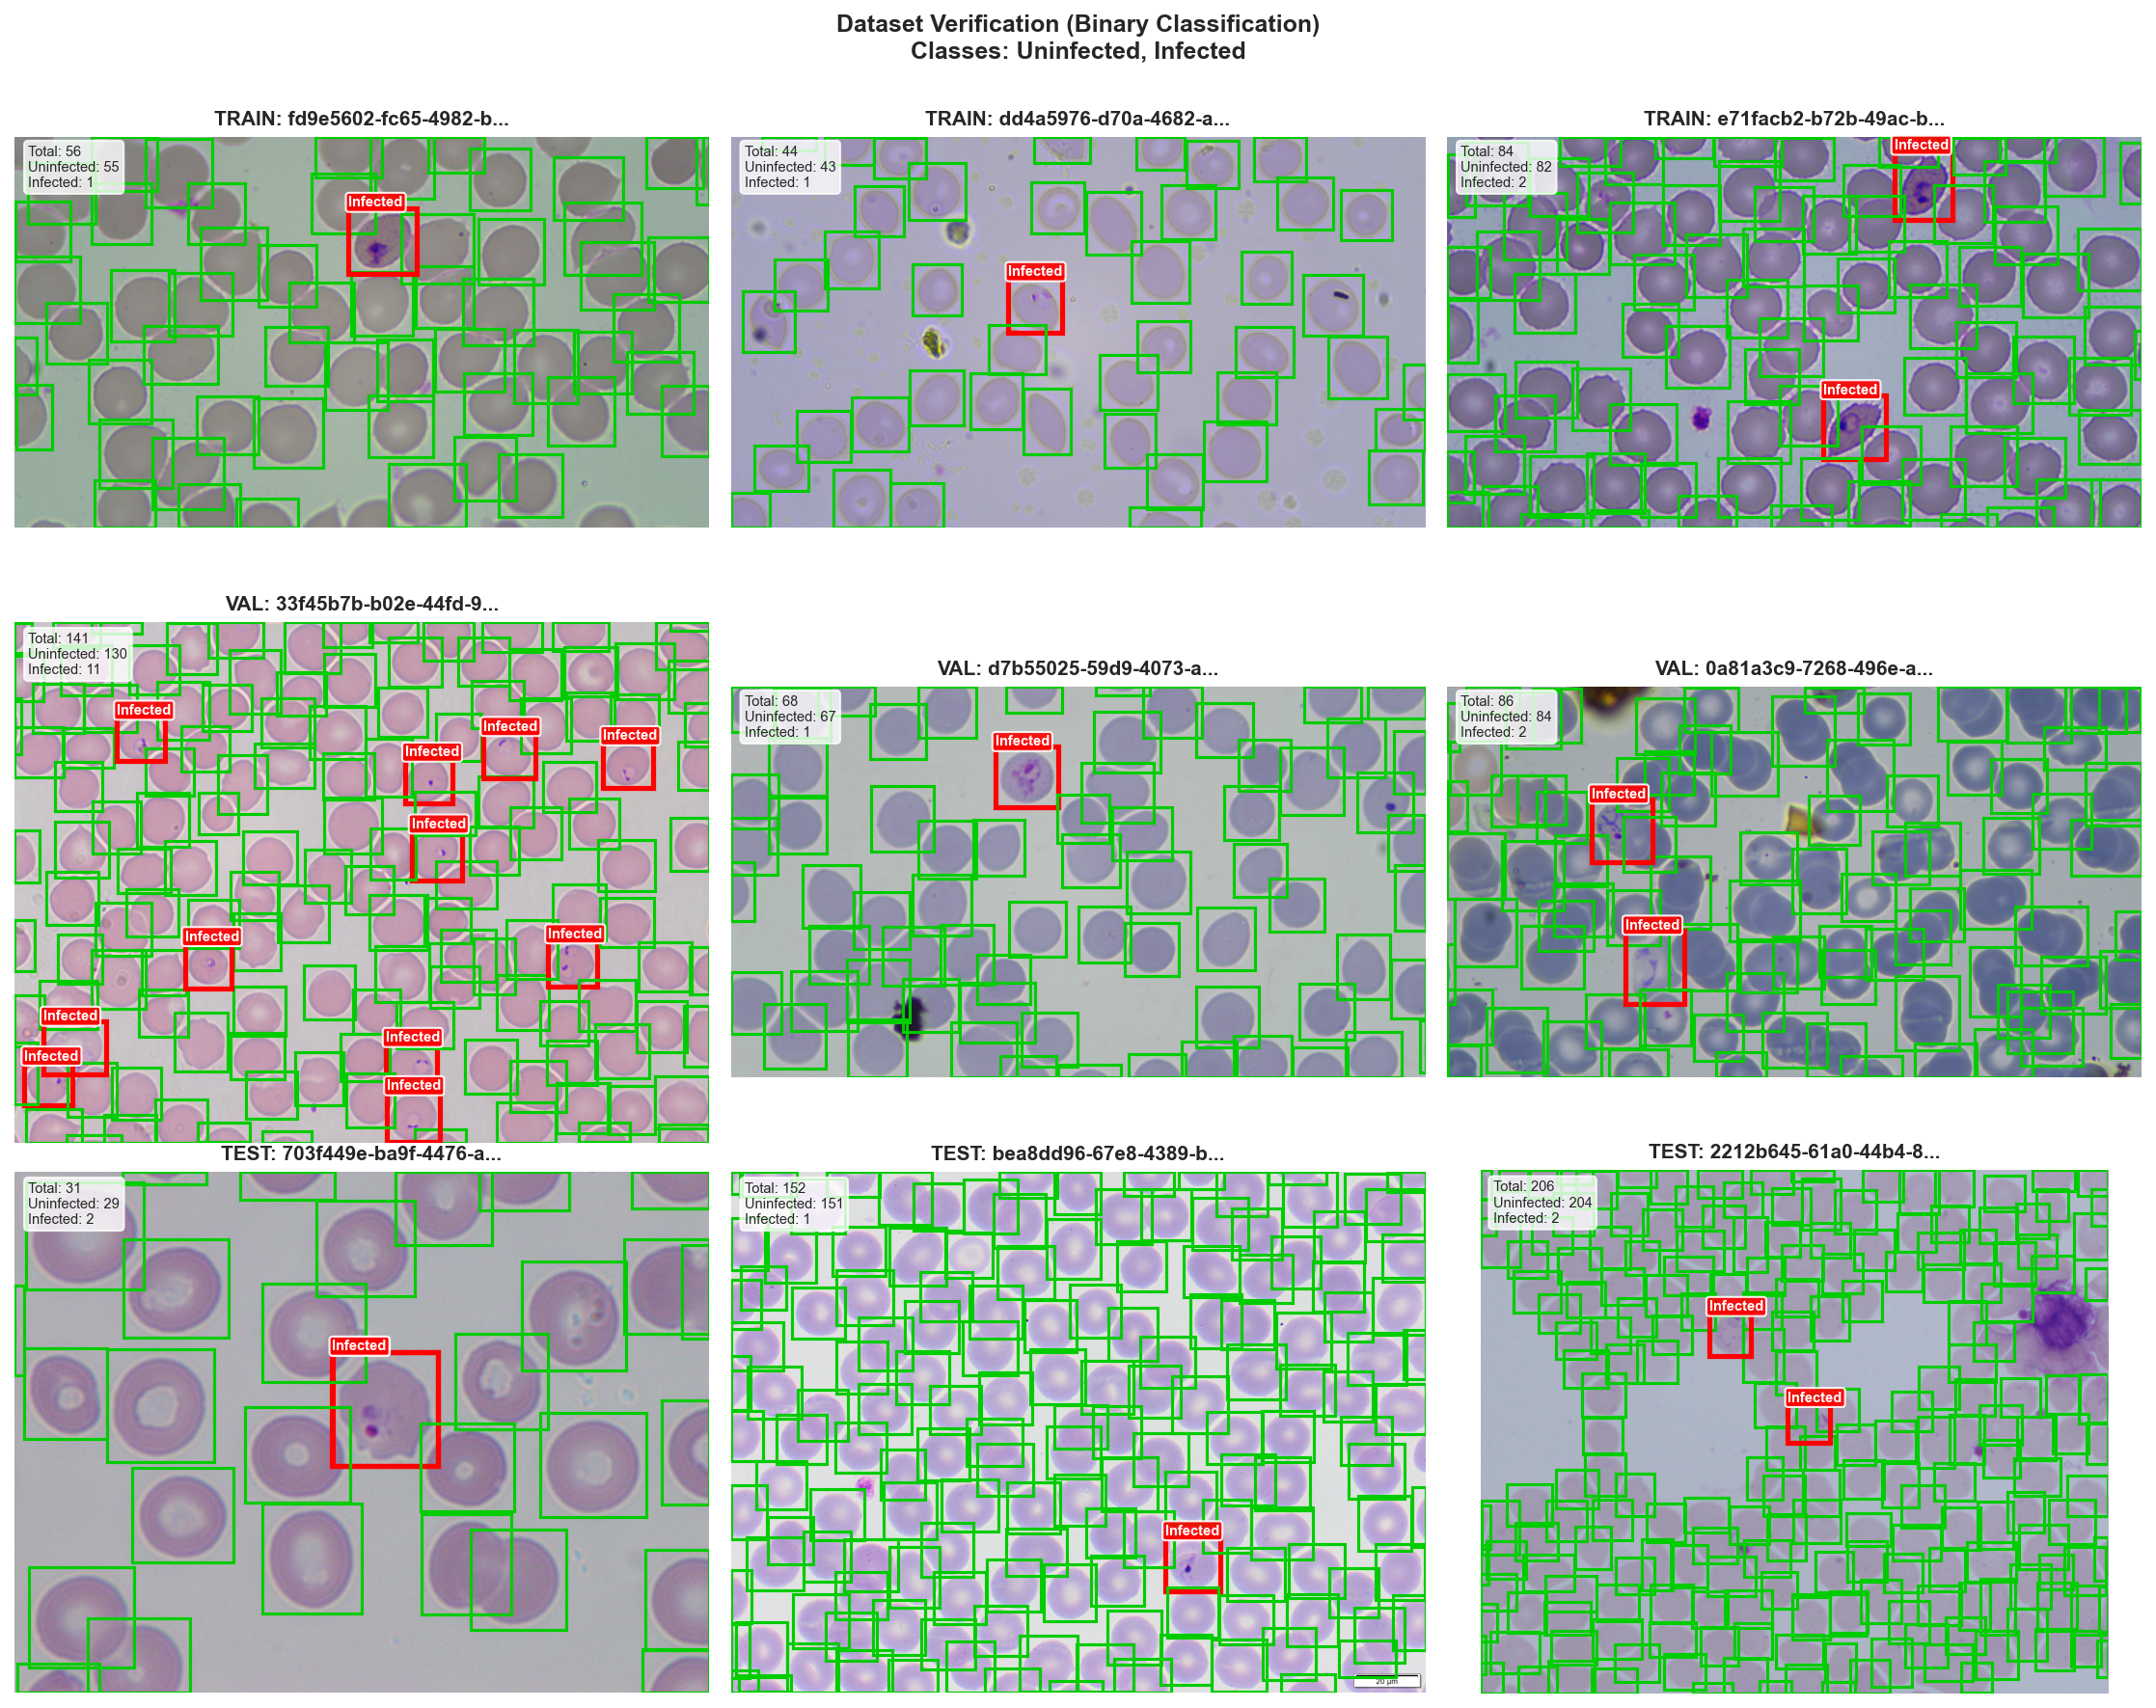


DATASET STATISTICS

OVERALL:
  Total images: 29228
  Total annotations: 2290921

  Class Distribution:
    Uninfected: 2,230,998 (97.4%)
    Infected: 59,923 (2.6%)

  Class Imbalance Ratio: 37.2:1

TRAIN Split:
  Images: 20830
  Total boxes: 1,625,173
  Images with minority classes: 15284
  Avg boxes/image: 78.0

VAL Split:
  Images: 3890
  Total boxes: 317,580
  Images with minority classes: 2857
  Avg boxes/image: 81.6

TEST Split:
  Images: 4508
  Total boxes: 348,168
  Images with minority classes: 2607
  Avg boxes/image: 77.2

READY FOR TRAINING


In [17]:
# Cell 4: Dataset Visualization and Statistics (Modular)

# Cell 4: Dataset Visualization and Statistics (Modular)

# Create visualizer - enable debug mode for D3 to see dimension issues
#debug_mode = (config.dataset == 'd3')  # Enable debug for D3
visualizer = YOLOVisualizer(config.get_class_names())

print("="*60)
print(f"DATASET VISUALIZATION: {config.dataset.upper()} - {config.task.upper()}")
print("="*60)

# Visualize samples (reduced to 3 per split for clarity)
fig = visualizer.visualize_dataset_samples(yolo_path, num_samples=3)
plt.show()


# Get and display statistics
print("\n" + "="*60)
print("DATASET STATISTICS")
print("="*60)

stats = visualizer.get_dataset_stats(yolo_path)

# Overall summary
total_images = sum(s['images'] for s in stats.values())
total_boxes = sum(s['total_boxes'] for s in stats.values())

print(f"\nOVERALL:")
print(f"  Total images: {total_images}")
print(f"  Total annotations: {total_boxes}")

# Class distribution
total_per_class = {}
for s in stats.values():
    for class_id, count in s['class_distribution'].items():
        total_per_class[class_id] = total_per_class.get(class_id, 0) + count

print(f"\n  Class Distribution:")
for class_id in sorted(total_per_class.keys()):
    count = total_per_class[class_id]
    class_name = config.get_class_names().get(class_id)
    percentage = (count/total_boxes*100) if total_boxes > 0 else 0
    print(f"    {class_name}: {count:,} ({percentage:.1f}%)")

# Identify imbalance
if len(total_per_class) > 0:
    max_count = max(total_per_class.values())
    min_count = min(total_per_class.values())
    if min_count > 0:
        imbalance_ratio = max_count / min_count
        print(f"\n  Class Imbalance Ratio: {imbalance_ratio:.1f}:1")

# Per-split details
for split, split_stats in stats.items():
    print(f"\n{split.upper()} Split:")
    print(f"  Images: {split_stats['images']}")
    print(f"  Total boxes: {split_stats['total_boxes']:,}")
    if visualizer.minority_classes:
        print(f"  Images with minority classes: {split_stats['images_with_minority']}")
    print(f"  Avg boxes/image: {split_stats['avg_boxes_per_image']:.1f}")

print("\n" + "="*60)
print("READY FOR TRAINING" if total_boxes > 0 else "NO ANNOTATIONS FOUND")
print("="*60)

In [18]:
# Cell 5: Initialize Model
from ultralytics import YOLO

# Download/load pretrained weights
if config.model_name == 'yolov8s':
    model = YOLO('yolov8s.pt')
elif config.model_name == 'yolo11s':
    model = YOLO('yolo11s.pt')  
else:
    raise ValueError(f"Model {config.model_name} not implemented yet")

print(f"Model loaded: {config.model_name}")


Model loaded: yolo11s


In [19]:
# Cell 7: W&B Initialization with Real-Time Logging Setup
import wandb
import time
from datetime import datetime
import torch

# Initialize tracking variables
training_metrics = {
    'start_time': None,
    'end_time': None,
    'total_training_time': 0,
    'inference_times': [],
    'epoch_times': [],
    'best_metrics': {}  # Added for tracking best performance during training
}

if config.use_wandb:
    wandb.login(key=config.wandb_key)
    
    # More comprehensive config with safe attribute access
    wandb_config = {
        # Model architecture
        'model': config.model_name,
        'parameters': None,  # Will update after model loads
        
        # Training hyperparameters
        'epochs': config.epochs,
        'batch_size': config.batch_size,
        'learning_rate': config.lr0,
        'optimizer': config.optimizer,
        'momentum': config.momentum,
        'weight_decay': config.weight_decay,
        
        # Dataset info
        'dataset': config.dataset,
        'task': config.task,
        'num_classes': len(config.get_class_names()),
        'train_images': len(list((yolo_path / 'train' / 'images').glob('*.jpg'))),
        'val_images': len(list((yolo_path / 'val' / 'images').glob('*.jpg'))),
        'test_images': len(list((yolo_path / 'test' / 'images').glob('*.jpg'))),
        
        # Hardware info
        'device': 'cuda' if torch.cuda.is_available() else 'cpu',
        'num_workers': getattr(config, 'workers', 8),  # Default to 8 if not set
        
        # Experiment metadata
        'timestamp': datetime.now().isoformat(),
        'experiment_type': getattr(config, 'training_strategy', 'no_weights'),
        
        # Additional configs if they exist
        'patience': getattr(config, 'patience', 20),
        'warmup_epochs': getattr(config, 'warmup_epochs', 3.0),
        'save_period': getattr(config, 'save_period', 10),
    }
    
    # Add strategy to tags if it exists
    tags = [config.dataset, config.task, config.model_name]
    strategy = getattr(config, 'training_strategy', 'no_weights')
    tags.append(strategy)
    
    # Initialize W&B run
    run = wandb.init(
        project=config.wandb_project,
        name=experiment_name,
        config=wandb_config,
        tags=tags
    )
    
    # Define custom metrics for proper x-axis tracking in charts
    wandb.define_metric("epoch")
    wandb.define_metric("train/*", step_metric="epoch")
    wandb.define_metric("val/*", step_metric="epoch")
    wandb.define_metric("metrics/*", step_metric="epoch")
    wandb.define_metric("lr/*", step_metric="epoch")
    
    print(f"✓ W&B initialized: {run.name}")
    print(f"✓ View run at: {run.url}")
    print(f"✓ Real-time logging configured")
else:
    print("W&B logging disabled")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/thabangisaka/.netrc
wandb: Currently logged in as: thabangisaac726 (leraning) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


✓ W&B initialized: yolo11s_d3_binary_baseline
✓ View run at: https://wandb.ai/leraning/malaria_qgfl_experiments/runs/4dlvo7av
✓ Real-time logging configured


In [ ]:
# Cell 8: Complete Training with Post-Training W&B Logging
from ultralytics import YOLO
import time
from pathlib import Path
from collections import defaultdict
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wandb
from src.training.strategy_wrapper import create_training_strategy

print("="*70)
print(f"TRAINING PIPELINE")
print("="*70)

# Verify required variables
assert 'config' in globals(), "config not found - run Cell 1 first"
assert 'yolo_path' in globals(), "yolo_path not found - run Cell 3 first"

# Define yaml_file path
yaml_file = Path(f'../configs/data_yamls/{config.dataset}_{config.task}.yaml')
if not yaml_file.exists():
    raise FileNotFoundError(f"YAML file not found: {yaml_file}")
print(f"Using YAML config: {yaml_file}")

# Get class distribution from training data
def get_class_distribution(yolo_path):
    """Calculate class distribution from training labels"""
    distribution = defaultdict(int)
    label_dir = yolo_path / 'train' / 'labels'
    
    for class_id, class_name in config.get_class_names().items():
        distribution[class_name] = 0
    
    for label_file in label_dir.glob('*.txt'):
        with open(label_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 5:
                    class_id = int(parts[0])
                    class_name = config.get_class_names()[class_id]
                    distribution[class_name] += 1
    
    return dict(distribution)

# Calculate distribution
print("\nCalculating class distribution...")
class_distribution = get_class_distribution(yolo_path)
total_annotations = sum(class_distribution.values())

print(f"\nTraining Set Statistics:")
print(f"  Total annotations: {total_annotations}")
for class_name, count in class_distribution.items():
    percentage = (count / total_annotations * 100) if total_annotations > 0 else 0
    print(f"  {class_name}: {count} ({percentage:.1f}%)")

# Select training strategy
TRAINING_STRATEGY = getattr(config, 'training_strategy', 'no_weights')
print(f"\nSelected Strategy: {TRAINING_STRATEGY}")

# Create strategy
strategy = create_training_strategy(TRAINING_STRATEGY, config, class_distribution)
strategy_params = strategy.get_training_params()
hyperparameter_adjustments = strategy.get_hyperparameter_adjustments()

# Update experiment name
experiment_name = f"{config.model_name}_{config.dataset}_{config.task}_{strategy.get_strategy_name()}"
print(f"\nExperiment Name: {experiment_name}")

# Update W&B config if active
if config.use_wandb:
    if not hasattr(wandb, 'run') or wandb.run is None:
        raise RuntimeError("W&B not initialized. Run Cell 7 first")
    
    wandb.config.update({
        'training_strategy': strategy.get_strategy_name(),
        'class_distribution': class_distribution,
        'minority_classes': [config.get_class_names()[i] for i in strategy.minority_classes],
        'class_weights': strategy.class_weights.tolist(),
        'total_training_annotations': total_annotations
    })
    
    wandb.run.name = experiment_name

# Track training start time
training_start_time = time.time()

# Load model
print(f"\nLoading model: {config.model_name}.pt")
model = YOLO(f'{config.model_name}.pt')

# Get model info for W&B
if config.use_wandb:
    try:
        total_params = sum(p.numel() for p in model.model.parameters())
        trainable_params = sum(p.numel() for p in model.model.parameters() if p.requires_grad)
        wandb.config.update({
            'total_parameters': total_params,
            'trainable_parameters': trainable_params,
            'model_size_mb': total_params * 4 / (1024 * 1024)
        })
        print(f"Model Parameters: {total_params:,} total, {trainable_params:,} trainable")
    except:
        pass

# Apply hyperparameter adjustments
for param, value in hyperparameter_adjustments.items():
    if hasattr(config, param):
        old_value = getattr(config, param)
        print(f"Adjusting {param}: {old_value} -> {value}")
        setattr(config, param, value)

# Prepare training arguments (NO W&B project parameter)
# Cell 8: Complete Training with Post-Training W&B Logging (UPDATED)
from ultralytics import YOLO
import time
from pathlib import Path
from collections import defaultdict
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wandb
from src.training.strategy_wrapper import create_training_strategy

print("="*70)
print(f"TRAINING PIPELINE")
print("="*70)

# [All setup code remains the same until train_args]

# Prepare training arguments with FIXED folder structure
train_args = {
    'data': str(yaml_file),
    'epochs': config.epochs,
    'imgsz': config.imgsz,
    'batch': config.batch_size,
    'name': experiment_name,
    'project': '../runs/detect',  # ADDED: Controls where YOLO saves to avoid nested folders
    'device': 'cpu' if not torch.cuda.is_available() else None,
    'patience': getattr(config, 'patience', 20),
    'save': True,
    'save_period': getattr(config, 'save_period', 10),
    'val': getattr(config, 'val', True),
    'amp': getattr(config, 'amp', True),
    'exist_ok': getattr(config, 'exist_ok', True),
    'seed': getattr(config, 'seed', 42),
    'deterministic': getattr(config, 'deterministic', True),
    'single_cls': getattr(config, 'single_cls', False),
    'rect': getattr(config, 'rect', False),
    'cos_lr': getattr(config, 'cos_lr', False),
    'resume': getattr(config, 'resume', False),
    
    # [Rest of parameters remain the same]
    'optimizer': getattr(config, 'optimizer', 'SGD'),
    'lr0': getattr(config, 'lr0', 0.005),
    'lrf': getattr(config, 'lrf', 0.01),
    'momentum': getattr(config, 'momentum', 0.95),
    'weight_decay': getattr(config, 'weight_decay', 0.0005),
    'warmup_epochs': getattr(config, 'warmup_epochs', 3.0),
    'warmup_momentum': getattr(config, 'warmup_momentum', 0.8),
    'warmup_bias_lr': getattr(config, 'warmup_bias_lr', 0.1),
    
    'box': strategy_params.get('box', 7.5),
    'cls': strategy_params.get('cls', 0.5),
    'dfl': strategy_params.get('dfl', 1.5),
    
    'hsv_h': getattr(config, 'hsv_h', 0.015),
    'hsv_s': getattr(config, 'hsv_s', 0.7),
    'hsv_v': getattr(config, 'hsv_v', 0.4),
    'degrees': getattr(config, 'degrees', 0.0),
    'translate': getattr(config, 'translate', 0.1),
    'scale': getattr(config, 'scale', 0.5),
    'shear': getattr(config, 'shear', 0.0),
    'perspective': getattr(config, 'perspective', 0.0),
    'flipud': getattr(config, 'flipud', 0.0),
    'fliplr': getattr(config, 'fliplr', 0.5),
    'mosaic': getattr(config, 'mosaic', 1.0),
    'mixup': getattr(config, 'mixup', 0.0),
    'copy_paste': getattr(config, 'copy_paste', 0.0),
    
    'overlap_mask': getattr(config, 'overlap_mask', True),
    'mask_ratio': getattr(config, 'mask_ratio', 4),
    'dropout': getattr(config, 'dropout', 0.0),
    
    'plots': getattr(config, 'plots', True),
    'verbose': getattr(config, 'verbose', True),
    
    'workers': getattr(config, 'workers', 8),
}


print(f"\nStarting training for {config.epochs} epochs...")
print(f"Strategy: {strategy.get_strategy_name()}")
print(f"Loss weights - Box: {train_args['box']}, Cls: {train_args['cls']}, DFL: {train_args['dfl']}")
print("\n" + "="*50)
print("MONITOR CONSOLE OUTPUT FOR REAL-TIME PROGRESS")
print("Metrics will be logged to W&B after completion")
print("="*50 + "\n")

# Train model
try:
    results = model.train(**train_args)
except Exception as e:
    print(f"Training error: {e}")
    if config.use_wandb:
        wandb.alert(title="Training Failed", text=str(e))
    raise

# Calculate training time
training_end_time = time.time()
total_training_time = training_end_time - training_start_time

print(f"\n{'='*60}")
print(f"TRAINING COMPLETED")
print(f"{'='*60}")
print(f"Total training time: {total_training_time/60:.2f} minutes")
print(f"Average time per epoch: {total_training_time/config.epochs:.2f} seconds")

# Store metrics for later use
training_metrics['total_training_time'] = total_training_time
training_metrics['end_time'] = training_end_time

# Get paths
best_model_path = Path(results.save_dir) / 'weights' / 'best.pt'
last_model_path = Path(results.save_dir) / 'weights' / 'last.pt'
results_csv = Path(results.save_dir) / 'results.csv'

# LOG COMPREHENSIVE TRAINING DATA TO W&B
if config.use_wandb and results_csv.exists():
    print("\n" + "="*50)
    print("LOGGING TRAINING METRICS TO W&B")
    print("="*50)
    
    # 1. Read and log training curves
    df = pd.read_csv(results_csv)
    df.columns = [col.strip() for col in df.columns]  # Clean column names
    
    print(f"Logging {len(df)} epochs of training data...")
    
    # Log each epoch's metrics
    for idx, row in df.iterrows():
        epoch = int(row['epoch'])
        
        metrics = {
            # Training losses
            'train/box_loss': float(row['train/box_loss']) if 'train/box_loss' in row else None,
            'train/cls_loss': float(row['train/cls_loss']) if 'train/cls_loss' in row else None,
            'train/dfl_loss': float(row['train/dfl_loss']) if 'train/dfl_loss' in row else None,
            
            # Validation losses
            'val/box_loss': float(row['val/box_loss']) if 'val/box_loss' in row else None,
            'val/cls_loss': float(row['val/cls_loss']) if 'val/cls_loss' in row else None,
            'val/dfl_loss': float(row['val/dfl_loss']) if 'val/dfl_loss' in row else None,
            
            # Performance metrics
            'metrics/precision': float(row['metrics/precision(B)']) if 'metrics/precision(B)' in row else None,
            'metrics/recall': float(row['metrics/recall(B)']) if 'metrics/recall(B)' in row else None,
            'metrics/mAP50': float(row['metrics/mAP50(B)']) if 'metrics/mAP50(B)' in row else None,
            'metrics/mAP50-95': float(row['metrics/mAP50-95(B)']) if 'metrics/mAP50-95(B)' in row else None,
        }
        
        # Remove None values
        metrics = {k: v for k, v in metrics.items() if v is not None}
        
        # Log with epoch as step
        wandb.log(metrics, step=epoch)
    
    # 2. Find and log best epoch
    best_map50_idx = df['metrics/mAP50(B)'].idxmax()
    best_epoch = int(df.loc[best_map50_idx, 'epoch'])
    best_map50 = float(df.loc[best_map50_idx, 'metrics/mAP50(B)'])
    
    training_metrics['best_metrics'] = {
        'epoch': best_epoch,
        'mAP50': best_map50
    }
    
    # 3. Log training plots if they exist
    plots_path = Path(results.save_dir)
    plot_files = ['results.png', 'confusion_matrix.png', 'F1_curve.png', 
                  'P_curve.png', 'R_curve.png', 'PR_curve.png']
    
    for plot_file in plot_files:
        plot_path = plots_path / plot_file
        if plot_path.exists():
            wandb.log({f"training_plots/{plot_file.split('.')[0]}": wandb.Image(str(plot_path))})
            print(f"  ✓ Logged {plot_file}")
    
    # 4. Log final summary metrics
    wandb.log({
        'summary/total_training_time_min': total_training_time/60,
        'summary/avg_epoch_time_sec': total_training_time/config.epochs,
        'summary/best_epoch': best_epoch,
        'summary/best_mAP50': best_map50,
        'summary/final_mAP50': float(df.iloc[-1]['metrics/mAP50(B)']),
        'summary/training_completed': True,
    })
    
    # Update run summary
    wandb.run.summary.update({
        'training_completed': True,
        'total_epochs': config.epochs,
        'best_epoch': best_epoch,
        'best_mAP50': best_map50,
        'total_training_time_minutes': total_training_time/60
    })
    
    # Log strategy-specific metrics
    strategy.log_strategy_metrics({})
    
    print(f"\n✓ Successfully logged all training metrics to W&B")
    print(f"✓ Best mAP50: {best_map50:.4f} at epoch {best_epoch}")
    
else:
    print("\n⚠️ No results.csv found or W&B disabled - skipping metric logging")

print(f"\nModel weights saved:")
print(f"  Best: {best_model_path}")
print(f"  Last: {last_model_path}")

# Save paths for next cells
model_paths = {
    'best': best_model_path,
    'last': last_model_path,
    'results_dir': results.save_dir
}

print(f"\nReady for evaluation!")

TRAINING PIPELINE
Using YAML config: ../configs/data_yamls/d3_binary.yaml

Calculating class distribution...

Training Set Statistics:
  Total annotations: 1625173
  Uninfected: 1579752 (97.2%)
  Infected: 45421 (2.8%)

Selected Strategy: no_weights

Initializing Training Strategy: NO_WEIGHTS

Strategy: NO_WEIGHTS (True Baseline)
All classes weighted equally: 1.0
Expected: High accuracy but poor minority recall

Experiment Name: yolo11s_d3_binary_no_weights

Loading model: yolo11s.pt
Model Parameters: 9,458,752 total, 0 trainable
TRAINING PIPELINE

Starting training for 10 epochs...
Strategy: no_weights
Loss weights - Box: 7.5, Cls: 0.5, DFL: 1.5

MONITOR CONSOLE OUTPUT FOR REAL-TIME PROGRESS
Metrics will be logged to W&B after completion

New https://pypi.org/project/ultralytics/8.3.204 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.199 🚀 Python-3.11.5 torch-2.8.0 CPU (Apple M2 Pro)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaug

/Users/thabangisaka/Downloads/thabang_phd/Experiments/Year 3 Experiments/malaria_experiments/.venv/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


train: Scanning /Users/thabangisaka/Downloads/thabang_phd/Experiments/Year 3 Experiments/malaria_experiments/dataset_d3/yolo_format/binary/train/labels... 20514 images, 316 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 20830/20830 2.4Kit/s 8.6s0.1s
train: New cache created: /Users/thabangisaka/Downloads/thabang_phd/Experiments/Year 3 Experiments/malaria_experiments/dataset_d3/yolo_format/binary/train/labels.cache
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1203.2±661.0 MB/s, size: 1664.4 KB)
val: Scanning /Users/thabangisaka/Downloads/thabang_phd/Experiments/Year 3 Experiments/malaria_experiments/dataset_d3/yolo_format/binary/val/labels... 3890 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 3890/3890 2.2Kit/s 1.8s0.1s
val: New cache created: /Users/thabangisaka/Downloads/thabang_phd/Experiments/Year 3 Experiments/malaria_experiments/dataset_d3/yolo_format/binary/val/labels.cache
Plotting labels to /Users/thabangisaka/Downloads/thabang_phd/Experiments/Year 3 Experiments/malaria_e

In [ ]:
# Cell 10: Initialize Evaluator
print("="*70)
print("INITIALIZING COMPREHENSIVE EVALUATOR")
print("="*70)


evaluator = ComprehensiveEvaluator(
    model_path=best_model_path,
    dataset_path=yolo_path,
    config=config,
    output_dir=Path('../results') / experiment_name / 'evaluation'
)

print(f"✓ Model loaded: {config.model_name}")
print(f"✓ Dataset: {config.dataset.upper()}")
print(f"✓ Task: {config.task}")
print(f"✓ Output directory created")

In [ ]:
# Cell 11: Global Metrics - Validation Set
print("\n" + "="*70)
print("VALIDATION SET - GLOBAL METRICS")
print("="*70)

val_results = evaluator.run_full_evaluation(split='val')

# Create formatted table
val_global_data = []
val_global_data.append(['mAP@0.5', f"{val_results['global']['mAP50']:.4f}"])
val_global_data.append(['mAP@[0.5:0.95]', f"{val_results['global']['mAP50-95']:.4f}"])
val_global_data.append(['Mean Precision', f"{val_results['global'].get('precision', 0):.4f}"])
val_global_data.append(['Mean Recall', f"{val_results['global'].get('recall', 0):.4f}"])

print("\n" + tabulate(val_global_data, 
                      headers=['Metric', 'Value'],
                      tablefmt='fancy_grid',
                      numalign='right'))

In [ ]:
# Cell 12: Global Metrics - Test Set
print("\n" + "="*70)
print("TEST SET - GLOBAL METRICS")
print("="*70)

test_results = evaluator.run_full_evaluation(split='test')

# Create formatted table
test_global_data = []
test_global_data.append(['mAP@0.5', f"{test_results['global']['mAP50']:.4f}"])
test_global_data.append(['mAP@[0.5:0.95]', f"{test_results['global']['mAP50-95']:.4f}"])
test_global_data.append(['Mean Precision', f"{test_results['global'].get('precision', 0):.4f}"])
test_global_data.append(['Mean Recall', f"{test_results['global'].get('recall', 0):.4f}"])

print("\n" + tabulate(test_global_data, 
                      headers=['Metric', 'Value'],
                      tablefmt='fancy_grid',
                      numalign='right'))

In [ ]:
# Cell 13A: Per-Class Performance Analysis - VALIDATION SET
print("\n" + "="*70)
print("VALIDATION SET - PER-CLASS PERFORMANCE")
print("="*70)

val_class_data = []
for class_name in config.get_class_names().values():
    metrics = val_results['per_class'].get(class_name, {})
    val_class_data.append([
        class_name,
        f"{metrics.get('precision', 0):.4f}",
        f"{metrics.get('recall', 0):.4f}",
        f"{metrics.get('f1_score', 0):.4f}",
        metrics.get('tp', 0),
        metrics.get('fp', 0),
        metrics.get('fn', 0),
        metrics.get('support', 0)
    ])

print("\n" + tabulate(val_class_data,
                      headers=['Class', 'Precision', 'Recall', 'F1-Score', 'TP', 'FP', 'FN', 'Support'],
                      tablefmt='fancy_grid',
                      numalign='right'))

In [ ]:
# Cell 8.5: MINIMAL FIX - Inference Time Tracking (Research-Appropriate)
import time
import numpy as np

print("\n" + "="*60)
print("INFERENCE TIME ANALYSIS")
print("="*60)

# Get all test images
test_images = list((yolo_path / 'test' / 'images').glob('*.jpg'))
print(f"Test set size: {len(test_images):,} images")

# FOR RESEARCH PAPER: Use 500 images for timing (statistically significant)
# but not so many that it takes forever
SAMPLE_SIZE = min(500, len(test_images))  # 500 is standard for timing benchmarks

# Random sample for better representation
import random
random.seed(42)
sampled_images = random.sample(test_images, SAMPLE_SIZE)
print(f"Using {SAMPLE_SIZE} images for inference timing\n")

inference_results = {}
batch_sizes = [1, 8, 16, 32] if torch.cuda.is_available() else [1, 4, 8]

model_eval = YOLO(best_model_path)

for batch_size in batch_sizes:
    times = []
    
    # Process ALL sampled images (not just 32!)
    for i in range(0, len(sampled_images), batch_size):
        batch = sampled_images[i:i+min(batch_size, len(sampled_images)-i)]
        
        start_time = time.time()
        results = model_eval.predict(batch, conf=0.5, iou=0.5, verbose=False)
        end_time = time.time()
        
        batch_time = end_time - start_time
        times.append(batch_time / len(batch))  # Time per image
    
    avg_time = np.mean(times) * 1000  # Convert to ms
    std_time = np.std(times) * 1000
    
    inference_results[f'batch_{batch_size}'] = {
        'mean_ms': avg_time,
        'std_ms': std_time,
        'fps': 1000/avg_time if avg_time > 0 else 0,
        'sample_size': SAMPLE_SIZE
    }
    
    print(f"Batch size {batch_size}: {avg_time:.2f}±{std_time:.2f} ms/image ({1000/avg_time:.1f} FPS)")

# Store for later
training_metrics['inference_results'] = inference_results
print(f"\n✓ Inference timing on {SAMPLE_SIZE} images complete")

In [ ]:
# Cell 13B: Per-Class Performance Analysis - TEST SET
print("\n" + "="*70)
print("TEST SET - PER-CLASS PERFORMANCE")
print("="*70)

test_class_data = []
for class_name in config.get_class_names().values():
    metrics = test_results['per_class'].get(class_name, {})
    test_class_data.append([
        class_name,
        f"{metrics.get('precision', 0):.4f}",
        f"{metrics.get('recall', 0):.4f}",
        f"{metrics.get('f1_score', 0):.4f}",
        metrics.get('tp', 0),
        metrics.get('fp', 0),
        metrics.get('fn', 0),
        metrics.get('support', 0)
    ])

print("\n" + tabulate(test_class_data,
                      headers=['Class', 'Precision', 'Recall', 'F1-Score', 'TP', 'FP', 'FN', 'Support'],
                      tablefmt='fancy_grid',
                      numalign='right'))

# Visualization comparing Val vs Test
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Per-Class Performance: Validation vs Test', fontsize=14, fontweight='bold')

classes = list(config.get_class_names().values())
x = np.arange(len(classes))
width = 0.35

# Precision comparison
val_prec = [val_results['per_class'].get(c, {}).get('precision', 0) for c in classes]
test_prec = [test_results['per_class'].get(c, {}).get('precision', 0) for c in classes]

axes[0].bar(x - width/2, val_prec, width, label='Validation', color='skyblue', edgecolor='navy')
axes[0].bar(x + width/2, test_prec, width, label='Test', color='lightcoral', edgecolor='darkred')
axes[0].set_ylabel('Precision', fontsize=11)
axes[0].set_title('Precision', fontsize=12)
axes[0].set_xticks(x)
axes[0].set_xticklabels(classes)
axes[0].legend()
axes[0].set_ylim(0, 1.05)
axes[0].grid(axis='y', alpha=0.3)

# Recall comparison
val_rec = [val_results['per_class'].get(c, {}).get('recall', 0) for c in classes]
test_rec = [test_results['per_class'].get(c, {}).get('recall', 0) for c in classes]

axes[1].bar(x - width/2, val_rec, width, label='Validation', color='skyblue', edgecolor='navy')
axes[1].bar(x + width/2, test_rec, width, label='Test', color='lightcoral', edgecolor='darkred')
axes[1].set_ylabel('Recall', fontsize=11)
axes[1].set_title('Recall', fontsize=12)
axes[1].set_xticks(x)
axes[1].set_xticklabels(classes)
axes[1].legend()
axes[1].set_ylim(0, 1.05)
axes[1].grid(axis='y', alpha=0.3)

# F1 comparison
val_f1 = [val_results['per_class'].get(c, {}).get('f1_score', 0) for c in classes]
test_f1 = [test_results['per_class'].get(c, {}).get('f1_score', 0) for c in classes]

axes[2].bar(x - width/2, val_f1, width, label='Validation', color='skyblue', edgecolor='navy')
axes[2].bar(x + width/2, test_f1, width, label='Test', color='lightcoral', edgecolor='darkred')
axes[2].set_ylabel('F1-Score', fontsize=11)
axes[2].set_title('F1-Score', fontsize=12)
axes[2].set_xticks(x)
axes[2].set_xticklabels(classes)
axes[2].legend()
axes[2].set_ylim(0, 1.05)
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
save_path = Path('../results') / experiment_name / 'per_class_comparison.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Cell 14: Recall Variability Analysis - UPDATED WITH WANDB TABLE FIX
if config.task == 'binary':
    print("\n" + "="*70)
    print("RECALL VARIABILITY ANALYSIS")
    print("="*70)
    
    # Collect per-image data
    img_dir = yolo_path / 'test' / "images"
    lbl_dir = yolo_path / 'test' / "labels"
    
    infected_ratios = []
    infected_recalls = []
    image_names = []
    
    img_files = list(img_dir.glob('*.jpg')) + list(img_dir.glob('*.png'))
    
    for img_path in tqdm(img_files, desc="Analyzing recall variability"):
        label_path = lbl_dir / (img_path.stem + '.txt')
        
        if not label_path.exists():
            continue
            
        # Count GT boxes
        infected_gt = 0
        uninfected_gt = 0
        infected_boxes = []
        
        img = Image.open(img_path)
        img_width, img_height = img.size
        
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 5:
                    class_id = int(parts[0])
                    if class_id == 1:  # Infected
                        infected_gt += 1
                        x_center = float(parts[1]) * img_width
                        y_center = float(parts[2]) * img_height
                        width = float(parts[3]) * img_width
                        height = float(parts[4]) * img_height
                        infected_boxes.append([
                            x_center - width/2, y_center - height/2,
                            x_center + width/2, y_center + height/2
                        ])
                    else:
                        uninfected_gt += 1
        
        total_gt = infected_gt + uninfected_gt
        if total_gt == 0 or infected_gt == 0:
            continue
        
        # Calculate infected ratio
        infected_ratio = (infected_gt / total_gt) * 100
        
        # Get predictions and calculate recall
        results = evaluator.model.predict(img_path, conf=0.5, iou=0.5, verbose=False)[0]
        
        infected_tp = 0
        if results.boxes is not None:
            for box in results.boxes:
                if int(box.cls.item()) == 1:  # Infected prediction
                    pred_box = box.xyxy[0].tolist()
                    # Check if matches any infected GT
                    for gt_box in infected_boxes:
                        iou = evaluator._compute_iou(pred_box, gt_box)
                        if iou > 0.5:
                            infected_tp += 1
                            break
        
        infected_recall = infected_tp / infected_gt
        infected_ratios.append(infected_ratio)
        infected_recalls.append(infected_recall)
        image_names.append(img_path.stem)
    
    # SAVE DATA
    import pandas as pd
    
    # Create DataFrame
    recall_df = pd.DataFrame({
        'image_id': image_names,
        'infected_ratio_percent': infected_ratios,
        'infected_recall': infected_recalls
    })
    
    # Save to CSV
    csv_path = Path('../results') / experiment_name / 'recall_variability_data.csv'
    recall_df.to_csv(csv_path, index=False)
    print(f"Saved recall data to: {csv_path}")
    
    # CRITICAL FIX: Store data for W&B properly
    test_results['recall_variability'] = {
        'wandb_table': recall_df.to_dict('records'),  # This creates the wandb_table
        'summary': {
            'n_images': len(infected_ratios),
            'mean_recall': float(np.mean(infected_recalls)) if infected_recalls else 0,
            'std_recall': float(np.std(infected_recalls)) if infected_recalls else 0,
            'min_recall': float(np.min(infected_recalls)) if infected_recalls else 0,
            'max_recall': float(np.max(infected_recalls)) if infected_recalls else 0
        }
    }
    
    # [REST OF VISUALIZATION CODE REMAINS THE SAME - scatter plot, etc.]
    # Create scatter plot
    fig, ax = plt.subplots(figsize=(12, 8))
    
    scatter = ax.scatter(infected_ratios, infected_recalls, 
                        c=infected_recalls, cmap='RdYlGn', 
                        s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
    
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Infected Cell Recall', fontsize=11)
    
    if len(infected_ratios) > 2:
        z = np.polyfit(infected_ratios, infected_recalls, 2)
        p = np.poly1d(z)
        x_trend = np.linspace(0, max(infected_ratios), 100)
        ax.plot(x_trend, p(x_trend), "b--", alpha=0.5, linewidth=2, label='Trend')
    
    ax.axvspan(0, 1, alpha=0.1, color='red', label='0-1% (Critical)')
    ax.axvspan(1, 3, alpha=0.1, color='orange', label='1-3% (Low density)')
    ax.axvspan(3, 5, alpha=0.1, color='yellow', label='3-5% (Medium)')
    ax.axvspan(5, max(infected_ratios) if infected_ratios else 10, 
               alpha=0.1, color='green', label='>5% (High density)')
    
    ax.set_xlabel('Infected Cell Ratio (%)', fontsize=12)
    ax.set_ylabel('Infected Cell Recall', fontsize=12)
    ax.set_title('Recall Variability: Per-Image Infected Cell Detection Performance', 
                fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlim(0, max(infected_ratios) * 1.1 if infected_ratios else 10)
    
    ax.text(0.02, 0.98, f'Total Images: {len(infected_ratios)}\n'
                        f'Mean Recall: {np.mean(infected_recalls):.3f}\n'
                        f'Std Recall: {np.std(infected_recalls):.3f}',
            transform=ax.transAxes, fontsize=10,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax.legend(loc='lower right', fontsize=10)
    
    plt.tight_layout()
    save_path = Path('../results') / experiment_name / 'recall_variability.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\nAnalyzed {len(infected_ratios)} images with infected cells")
    print(f"Mean recall: {np.mean(infected_recalls):.3f} ± {np.std(infected_recalls):.3f}")

In [ ]:
# Cell 14: Prevalence-Stratified Analysis - FINAL UPDATED VERSION
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
from pathlib import Path

if config.task == 'binary':
    print("\n" + "="*70)
    print("PREVALENCE-STRATIFIED ANALYSIS")
    print("="*70)
    
    stratified = test_results['stratified']
    
    # Using established bins from previous work
    bins = ['0-1%', '1-3%', '3-5%', '>5%']
    
    # Display results table
    strat_data = []
    for bin_name in bins:
        stats = stratified[bin_name]
        strat_data.append([
            bin_name,
            f"{stats['mean_recall']:.3f}",
            f"{stats['std_recall']:.3f}",
            stats['count']
        ])
    
    print("\n" + tabulate(strat_data,
                          headers=['Parasitemia Level', 'Mean Recall', 'Std Dev', 'N Images'],
                          tablefmt='fancy_grid',
                          numalign='right'))
    
    # Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle('Performance Across Parasitemia Levels', fontsize=14, fontweight='bold')
    
    recalls = [stratified[b]['mean_recall'] for b in bins]
    stds = [stratified[b]['std_recall'] for b in bins]
    counts = [stratified[b]['count'] for b in bins]
    
    # Color gradient from red (critical) to green (less critical)
    colors = ['#B71C1C', '#FF6F00', '#FDD835', '#43A047']
    
    # 1. Bar chart with error bars - ALL bins shown equally
    bars = []
    for i, (bin_name, recall, std, count) in enumerate(zip(bins, recalls, stds, counts)):
        bar = ax1.bar(i, recall, yerr=std if count > 0 else 0, 
                      capsize=5,
                      color=colors[i], 
                      edgecolor='black', 
                      linewidth=1.5,
                      alpha=0.8)  # Consistent opacity for all
        bars.append(bar)
    
    ax1.set_xticks(range(len(bins)))
    ax1.set_xticklabels(bins)
    ax1.set_xlabel('Parasitemia Level (%)', fontsize=12)
    ax1.set_ylabel('Mean Infected Cell Recall', fontsize=12)
    ax1.set_title('Recall by Parasitemia Level', fontsize=12)
    ax1.set_ylim(0, 1.05)
    ax1.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add clinical threshold
    ax1.axhline(y=0.8, color='green', linestyle=':', linewidth=1.5, alpha=0.7)
    ax1.text(3.5, 0.82, 'Target: 0.8', fontsize=9, color='green')
    
    # Add sample counts on bars - no warnings
    for i, (bar_container, count, recall) in enumerate(zip(bars, counts, recalls)):
        bar = bar_container[0]
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2, height + 0.02,
                f'n={count}', ha='center', va='bottom', 
                fontsize=9, fontweight='bold')
    
    # 2. Line plot with confidence intervals - ALL points shown
    x_pos = np.arange(len(bins))
    
    # Plot trend line with all points equally visible
    ax2.plot(x_pos, recalls, 'o-', markersize=10, linewidth=2.5, 
             color='#D32F2F', markeredgecolor='black', markeredgewidth=1,
             label='Mean Recall')
    
    # Add error bars for all points
    ax2.errorbar(x_pos, recalls, yerr=stds, fmt='none', 
                ecolor='#D32F2F', alpha=0.3, capsize=5, capthick=2)
    
    # Fill confidence interval
    ax2.fill_between(x_pos,
                     [r-s for r,s in zip(recalls, stds)],
                     [r+s for r,s in zip(recalls, stds)],
                     alpha=0.15, color='#D32F2F')
    
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(bins)
    ax2.set_xlabel('Parasitemia Level (%)', fontsize=12)
    ax2.set_ylabel('Mean Infected Cell Recall', fontsize=12)
    ax2.set_title('Performance Trend Across Parasitemia Levels', fontsize=12)
    ax2.set_ylim(0, 1.05)
    ax2.grid(True, alpha=0.3, linestyle='--')
    
    # Add clinical thresholds
    ax2.axhline(y=0.8, color='green', linestyle=':', linewidth=1.5, alpha=0.7, label='Clinical Target')
    ax2.axhline(y=0.5, color='orange', linestyle=':', linewidth=1.5, alpha=0.7, label='Minimum Acceptable')
    
    ax2.legend(loc='lower right', fontsize=10)
    
    plt.tight_layout()
    save_path = Path('../results') / experiment_name / 'stratified_analysis.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    # Clinical findings summary - no reliability warnings
    print("\n" + "="*50)
    print("CLINICAL PERFORMANCE SUMMARY")
    print("="*50)
    
    # Report all parasitemia levels
    print("Detection performance by parasitemia level:")
    for bin_name in bins:
        recall = stratified[bin_name]['mean_recall']
        std = stratified[bin_name]['std_recall']
        count = stratified[bin_name]['count']
        
        if bin_name == '0-1%':
            clinical_note = " [Ultra-low density - critical for early detection]"
        elif bin_name == '1-3%':
            clinical_note = " [Low density - most common in clinical practice]"
        elif bin_name == '3-5%':
            clinical_note = " [Medium density]"
        else:
            clinical_note = " [Higher density - easily detectable]"
        
        print(f"  {bin_name}: {recall:.3f} ± {std:.3f} (n={count}){clinical_note}")
    
    # Performance comparison
    if stratified['>5%']['mean_recall'] > 0 and stratified['1-3%']['mean_recall'] > 0:
        sparse_recall = stratified['1-3%']['mean_recall']
        dense_recall = stratified['>5%']['mean_recall']
        drop = (dense_recall - sparse_recall) / dense_recall * 100
        print(f"\nPerformance drop from high (>5%) to low (1-3%) density: {drop:.1f}%")
    
    # Critical low-parasitemia detection (<=3%)
    low_parasitemia_recalls = []
    low_parasitemia_counts = 0
    
    for bin_name in ['0-1%', '1-3%']:
        if stratified[bin_name]['count'] > 0:
            low_parasitemia_recalls.extend([stratified[bin_name]['mean_recall']] * stratified[bin_name]['count'])
            low_parasitemia_counts += stratified[bin_name]['count']
    
    if low_parasitemia_recalls:
        mean_low_parasitemia = np.mean(low_parasitemia_recalls)
        print(f"\nCombined performance for ≤3% parasitemia: {mean_low_parasitemia:.3f}")
        print(f"  Total images in this critical range: {low_parasitemia_counts}")
        
        if mean_low_parasitemia >= 0.8:
            print("  ✓ Meets clinical target for low-density detection")
        else:
            deficit = 0.8 - mean_low_parasitemia
            print(f"  → {deficit:.3f} below clinical target of 0.8")
    
    # Sample distribution analysis
    print(f"\nTest set parasitemia distribution:")
    total_samples = sum(counts)
    for bin_name, count in zip(bins, counts):
        percentage = (count / total_samples * 100) if total_samples > 0 else 0
        print(f"  {bin_name}: {count} images ({percentage:.1f}%)")
    
    # Note about sparse detection challenges
    if stratified['0-1%']['count'] > 0 or stratified['1-3%']['count'] > 0:
        print("\nNote: Low parasitemia (<3%) represents the most challenging")
        print("      and clinically important detection scenario.")

In [ ]:
# # Cell: Complete Reset and Reload
# import importlib
# import sys
# from pathlib import Path

# # 1. Clear ALL cached modules
# modules_to_clear = [k for k in sys.modules.keys() if 'evaluation' in k or 'evaluator' in k]
# for module in modules_to_clear:
#     del sys.modules[module]

# # 2. Also clear any .pyc files (compiled Python)
# import os
# import shutil
# pyc_path = Path('src/evaluation/__pycache__')
# if pyc_path.exists():
#     shutil.rmtree(pyc_path)
#     print(f"Cleared {pyc_path}")

# # 3. Force reimport
# from src.evaluation.evaluator import ComprehensiveEvaluator

# # 4. CREATE A NEW EVALUATOR OBJECT (Critical!)
# print("Creating NEW evaluator object with updated code...")
# evaluator = ComprehensiveEvaluator(
#     model_path=best_model_path,
#     dataset_path=yolo_path,
#     config=config,
#     output_dir=Path('../results') / experiment_name / 'evaluation'
# )

# # 5. Now run evaluation with the NEW evaluator
# print("Running evaluation with updated evaluator...")
# test_results = evaluator.run_full_evaluation(split='test')

# # 6. Verify the curve data is there
# pr_analysis = test_results.get('pr_analysis', {})
# for class_name in pr_analysis:
#     has_curves = 'precision_values' in pr_analysis[class_name]
#     print(f"{class_name}: Curves stored = {has_curves}")
#     if has_curves:
#         print(f"  - Points in curve: {len(pr_analysis[class_name]['precision_values'])}")

In [ ]:
# Cell 15: Enhanced Precision-Recall Curve Analysis with Professional Visualization
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
from pathlib import Path

print("\n" + "="*70)
print("PRECISION-RECALL ANALYSIS")
print("="*70)

pr_analysis = test_results['pr_analysis']

# Table
pr_data = []
for class_name, pr_stats in pr_analysis.items():
    pr_data.append([
        class_name,
        f"{pr_stats.get('ap', 0):.3f}",
        f"{pr_stats.get('optimal_threshold', 0):.3f}",
        f"{pr_stats.get('precision_at_optimal', 0):.3f}",
        f"{pr_stats.get('recall_at_optimal', 0):.3f}",
        f"{pr_stats.get('max_f1', 0):.3f}"
    ])

print("\n" + tabulate(pr_data,
                      headers=['Class', 'AP', 'Optimal Thresh', 'Precision', 'Recall', 'Max F1'],
                      tablefmt='fancy_grid',
                      numalign='right'))

# Create professional visualization
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

# Color scheme
colors = {'Uninfected': '#2E7D32', 'Infected': '#C62828'}  # Professional green/red
markers = {'Uninfected': 'o', 'Infected': 's'}

# 1. Main P-R Curves (Top row, spans 2 columns)
ax1 = fig.add_subplot(gs[0, :2])
ax1.set_title('Precision-Recall Curves', fontsize=14, fontweight='bold', pad=15)

# Plot curves with better styling
for class_name, pr_stats in pr_analysis.items():
    if 'precision_values' in pr_stats and 'recall_values' in pr_stats:
        # Get data
        recall = np.array(pr_stats['recall_values'])
        precision = np.array(pr_stats['precision_values'])
        
        # Plot main curve
        ax1.plot(recall, precision,
                color=colors.get(class_name, '#1976D2'),
                linewidth=2.5,
                label=f'{class_name} (AP = {pr_stats["ap"]:.3f})',
                alpha=0.9)
        
        # Add shaded area under curve
        ax1.fill_between(recall, 0, precision,
                         alpha=0.15,
                         color=colors.get(class_name, '#1976D2'))
        
        # Mark optimal operating point
        if 'recall_at_optimal' in pr_stats and 'precision_at_optimal' in pr_stats:
            ax1.plot(pr_stats['recall_at_optimal'], 
                    pr_stats['precision_at_optimal'],
                    marker=markers.get(class_name, 'o'),
                    markersize=12,
                    color=colors.get(class_name, '#1976D2'),
                    markeredgecolor='white',
                    markeredgewidth=2,
                    zorder=5)
            
            # Add annotation for optimal point
            ax1.annotate(f'F1={pr_stats["max_f1"]:.2f}',
                        xy=(pr_stats['recall_at_optimal'], pr_stats['precision_at_optimal']),
                        xytext=(10, -10), textcoords='offset points',
                        fontsize=9, color=colors.get(class_name, '#1976D2'),
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                                 edgecolor=colors.get(class_name, '#1976D2'), alpha=0.8))

# Add reference lines
ax1.axhline(y=0.5, color='gray', linestyle=':', alpha=0.3, linewidth=1)
ax1.axvline(x=0.5, color='gray', linestyle=':', alpha=0.3, linewidth=1)
ax1.plot([0, 1], [1, 0], 'k--', alpha=0.2, linewidth=1, label='Random')

# Formatting
ax1.set_xlabel('Recall (Sensitivity)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Precision (PPV)', fontsize=12, fontweight='bold')
ax1.set_xlim([-0.02, 1.02])
ax1.set_ylim([-0.02, 1.02])
ax1.grid(True, alpha=0.2, linestyle='-', linewidth=0.5)
ax1.legend(loc='lower left', fontsize=11, frameon=True, fancybox=True, 
          shadow=True, framealpha=0.95)

# Add performance zones
ax1.text(0.85, 0.85, 'Excellent', fontsize=9, alpha=0.3, ha='center')
ax1.text(0.5, 0.5, 'Good', fontsize=9, alpha=0.3, ha='center')
ax1.text(0.15, 0.15, 'Poor', fontsize=9, alpha=0.3, ha='center')

# 2. AP Bar Chart (Top right)
ax2 = fig.add_subplot(gs[0, 2])
classes = list(pr_analysis.keys())
aps = [pr_analysis[c]['ap'] for c in classes]

bars = ax2.barh(classes, aps, color=[colors.get(c, '#1976D2') for c in classes],
                edgecolor='white', linewidth=2, alpha=0.85, height=0.6)

# Add value labels
for i, (bar, ap) in enumerate(zip(bars, aps)):
    ax2.text(ap + 0.02, bar.get_y() + bar.get_height()/2,
             f'{ap:.3f}', va='center', fontsize=11, fontweight='bold')

ax2.set_xlim([0, 1.05])
ax2.set_xlabel('Average Precision', fontsize=11, fontweight='bold')
ax2.set_title('Average Precision Score', fontsize=12, fontweight='bold')
ax2.axvline(x=0.8, color='green', linestyle=':', alpha=0.4, linewidth=1.5)
ax2.text(0.8, -0.5, 'Target: 0.8', fontsize=9, color='green', ha='center')
ax2.grid(axis='x', alpha=0.2)

# 3. F1 Score vs Threshold (Bottom left)
ax3 = fig.add_subplot(gs[1, 0])

has_threshold_data = False
for class_name, pr_stats in pr_analysis.items():
    if 'thresholds' in pr_stats and 'f1_scores' in pr_stats:
        has_threshold_data = True
        thresholds = np.array(pr_stats['thresholds'])
        f1_scores = np.array(pr_stats['f1_scores'])
        
        # Smooth the curve if too many points
        if len(thresholds) > 100:
            # Sample points for smoother visualization
            indices = np.linspace(0, len(thresholds)-1, 100, dtype=int)
            thresholds = thresholds[indices]
            f1_scores = f1_scores[indices]
        
        ax3.plot(thresholds, f1_scores,
                color=colors.get(class_name, '#1976D2'),
                linewidth=2, label=class_name, alpha=0.9)
        
        # Mark optimal
        optimal_idx = np.argmax(pr_stats['f1_scores'])
        if optimal_idx < len(pr_stats['thresholds']):
            ax3.plot(pr_stats['thresholds'][optimal_idx],
                    pr_stats['f1_scores'][optimal_idx],
                    marker=markers.get(class_name, 'o'),
                    markersize=10,
                    color=colors.get(class_name, '#1976D2'),
                    markeredgecolor='white',
                    markeredgewidth=2)

ax3.set_xlabel('Confidence Threshold', fontsize=11, fontweight='bold')
ax3.set_ylabel('F1 Score', fontsize=11, fontweight='bold')
ax3.set_title('F1 Score vs Threshold', fontsize=12, fontweight='bold')
ax3.set_xlim([0, 1])
ax3.set_ylim([0, 1.05])
ax3.axvline(x=0.5, color='gray', linestyle=':', alpha=0.3, linewidth=1)
ax3.axhline(y=0.8, color='green', linestyle=':', alpha=0.3, linewidth=1)
ax3.grid(True, alpha=0.2)
ax3.legend(loc='best', fontsize=10)

# 4. Optimal Operating Points (Bottom middle)
ax4 = fig.add_subplot(gs[1, 1])
x = np.arange(len(classes))
width = 0.35

thresholds = [pr_analysis[c]['optimal_threshold'] for c in classes]
f1_scores = [pr_analysis[c]['max_f1'] for c in classes]

bars1 = ax4.bar(x - width/2, thresholds, width, label='Optimal Threshold',
                color='#1976D2', edgecolor='white', linewidth=2, alpha=0.85)
bars2 = ax4.bar(x + width/2, f1_scores, width, label='Max F1 Score',
                color='#FF6F00', edgecolor='white', linewidth=2, alpha=0.85)

# Add value labels
for bar, val in zip(bars1, thresholds):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f'{val:.2f}', ha='center', fontsize=9, fontweight='bold')
for bar, val in zip(bars2, f1_scores):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f'{val:.2f}', ha='center', fontsize=9, fontweight='bold')

ax4.set_ylabel('Score', fontsize=11, fontweight='bold')
ax4.set_title('Optimal Operating Points', fontsize=12, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(classes)
ax4.legend(loc='upper right', fontsize=10)
ax4.set_ylim(0, 1.15)
ax4.grid(axis='y', alpha=0.2)
ax4.axhline(y=0.5, color='gray', linestyle=':', alpha=0.3, linewidth=1)

# 5. Performance Summary (Bottom right)
ax5 = fig.add_subplot(gs[1, 2])
ax5.axis('off')

# Create summary text
summary_text = "Performance Summary\n" + "="*25 + "\n\n"

for class_name, pr_stats in pr_analysis.items():
    summary_text += f"{class_name}:\n"
    summary_text += f"  • AP: {pr_stats['ap']:.3f}\n"
    summary_text += f"  • Best F1: {pr_stats['max_f1']:.3f}\n"
    summary_text += f"  • Optimal Threshold: {pr_stats['optimal_threshold']:.2f}\n"
    summary_text += f"  • P@Optimal: {pr_stats['precision_at_optimal']:.3f}\n"
    summary_text += f"  • R@Optimal: {pr_stats['recall_at_optimal']:.3f}\n\n"

# Calculate overall performance
mean_ap = np.mean([pr_stats['ap'] for pr_stats in pr_analysis.values()])
summary_text += f"Mean AP: {mean_ap:.3f}"

ax5.text(0.1, 0.9, summary_text, transform=ax5.transAxes,
         fontsize=10, fontfamily='monospace',
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.1))

# Overall title
fig.suptitle('Precision-Recall Analysis Dashboard', fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout(rect=[0, 0.02, 1, 0.96])
save_path = Path('../results') / experiment_name / 'pr_curves_comprehensive.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# Key insights
print("\n" + "="*50)
print("KEY INSIGHTS")
print("="*50)

# Performance assessment
mean_ap = np.mean([pr_stats['ap'] for pr_stats in pr_analysis.values()])
print(f"Overall Mean AP: {mean_ap:.3f}")

if mean_ap >= 0.8:
    print("→ Excellent overall performance")
elif mean_ap >= 0.6:
    print("→ Good overall performance")
else:
    print("→ Performance needs improvement")

# Class balance
ap_diff = abs(pr_analysis['Infected']['ap'] - pr_analysis['Uninfected']['ap'])
if ap_diff > 0.1:
    print(f"\n⚠️ Significant AP difference between classes ({ap_diff:.3f})")
    print("   Consider class balancing techniques")

# Threshold recommendations
for class_name, pr_stats in pr_analysis.items():
    optimal = pr_stats.get('optimal_threshold', 0.5)
    if abs(optimal - 0.5) > 0.1:
        print(f"\n{class_name}: Optimal threshold ({optimal:.3f}) differs from default (0.5)")

In [ ]:
# Cell: TIDE Error Analysis - COMPLETE CORRECTED VERSION
print("\n" + "="*70)
print("TIDE ERROR ANALYSIS - CORRECTED")
print("="*70)

def compute_tide_errors_complete(evaluator, split='test', max_images=None):
    """Complete TIDE error analysis with CORRECTED per-class tracking"""
    
    img_dir = evaluator.dataset_path / split / "images"
    lbl_dir = evaluator.dataset_path / split / "labels"
    
    # Get all image files
    img_files = list(img_dir.glob('*.jpg'))
    
    # Apply limit if specified
    if max_images is not None:
        img_files = img_files[:max_images]
        print(f"Analyzing {max_images} images (subset)")
    else:
        print(f"Analyzing ALL {len(img_files)} images in test set")
    
    # Initialize raw counters
    errors_per_class_raw = {}
    for class_name in evaluator.class_names.values():
        errors_per_class_raw[class_name] = {
            'classification': [],  # When THIS class GT is misclassified
            'localization': [],    # When correctly classified but poorly localized
            'duplicate': [],        # When THIS class has duplicate detections
            'background': [],       # When THIS class is falsely detected (no GT)
            'missed': []           # When THIS class GT is not detected
        }
    
    errors_aggregate_raw = {
        'classification': [],
        'localization': [],
        'duplicate': [],
        'background': [],
        'missed': []
    }
    
    # Process images
    for img_path in tqdm(img_files, desc="Computing TIDE errors"):
        label_path = lbl_dir / (img_path.stem + '.txt')
        
        # Load GT boxes
        gt_boxes = []
        if label_path.exists():
            img = Image.open(img_path)
            img_width, img_height = img.size
            
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) >= 5:
                        class_id = int(parts[0])
                        x_center = float(parts[1]) * img_width
                        y_center = float(parts[2]) * img_height
                        width = float(parts[3]) * img_width
                        height = float(parts[4]) * img_height
                        
                        x1 = x_center - width/2
                        y1 = y_center - height/2
                        x2 = x_center + width/2
                        y2 = y_center + height/2
                        
                        gt_boxes.append({
                            'class_id': class_id,
                            'box': [x1, y1, x2, y2],
                            'matched': False
                        })
        
        # Get predictions
        results = evaluator.model.predict(img_path, conf=0.5, iou=0.5, verbose=False)[0]
        pred_boxes = []
        
        if results.boxes is not None:
            for box in results.boxes:
                pred_boxes.append({
                    'class_id': int(box.cls.item()),
                    'box': box.xyxy[0].tolist(),
                    'matched': False
                })
        
        # Match predictions to GT
        for pred_idx, pred in enumerate(pred_boxes):
            best_iou = 0
            best_gt_idx = -1
            
            for gt_idx, gt in enumerate(gt_boxes):
                if gt['matched']:
                    continue
                
                iou = evaluator._compute_iou(pred['box'], gt['box'])
                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = gt_idx
            
            pred_class_name = evaluator.class_names[pred['class_id']]
            
            if best_iou >= 0.5:  # Matched with GT
                gt = gt_boxes[best_gt_idx]
                gt_class_name = evaluator.class_names[gt['class_id']]
                
                if pred['class_id'] != gt['class_id']:
                    # Classification error - count ONLY for the GT class (what was actually there)
                    errors_per_class_raw[gt_class_name]['classification'].append(1)
                    errors_aggregate_raw['classification'].append(1)
                else:
                    # Correct class but localization error
                    loc_error = 1 - best_iou
                    errors_per_class_raw[pred_class_name]['localization'].append(loc_error)
                    errors_aggregate_raw['localization'].append(loc_error)
                
                gt['matched'] = True
                pred['matched'] = True
                
            else:  # No matching GT - background/false positive error
                errors_per_class_raw[pred_class_name]['background'].append(1)
                errors_aggregate_raw['background'].append(1)
        
        # Check for duplicate predictions
        for i in range(len(pred_boxes)):
            if pred_boxes[i]['matched']:
                continue
            for j in range(i+1, len(pred_boxes)):
                if pred_boxes[j]['matched']:
                    continue
                if pred_boxes[i]['class_id'] == pred_boxes[j]['class_id']:
                    iou = evaluator._compute_iou(pred_boxes[i]['box'], pred_boxes[j]['box'])
                    if iou > 0.5:
                        class_name = evaluator.class_names[pred_boxes[i]['class_id']]
                        errors_per_class_raw[class_name]['duplicate'].append(1)
                        errors_aggregate_raw['duplicate'].append(1)
                        pred_boxes[j]['matched'] = True  # Mark to avoid re-counting
        
        # Check for missed detections (unmatched GT)
        for gt in gt_boxes:
            if not gt['matched']:
                gt_class_name = evaluator.class_names[gt['class_id']]
                errors_per_class_raw[gt_class_name]['missed'].append(1)
                errors_aggregate_raw['missed'].append(1)
    
    # Calculate statistics
    n_images = len(img_files)
    
    final_errors_per_class = {}
    for class_name in evaluator.class_names.values():
        final_errors_per_class[class_name] = {}
        for error_type in ['classification', 'localization', 'duplicate', 'background', 'missed']:
            values = errors_per_class_raw[class_name][error_type]
            if values:
                final_errors_per_class[class_name][error_type] = {
                    'mean': np.mean(values),
                    'std': np.std(values),
                    'count': len(values),
                    'rate_per_image': len(values) / n_images
                }
            else:
                final_errors_per_class[class_name][error_type] = {
                    'mean': 0,
                    'std': 0,
                    'count': 0,
                    'rate_per_image': 0
                }
    
    final_errors_aggregate = {}
    for error_type in ['classification', 'localization', 'duplicate', 'background', 'missed']:
        values = errors_aggregate_raw[error_type]
        if values:
            final_errors_aggregate[error_type] = {
                'mean': np.mean(values),
                'std': np.std(values),
                'count': len(values),
                'rate_per_image': len(values) / n_images
            }
        else:
            final_errors_aggregate[error_type] = {
                'mean': 0,
                'std': 0,
                'count': 0,
                'rate_per_image': 0
            }
    
    return final_errors_aggregate, final_errors_per_class, n_images

# Run the CORRECTED TIDE analysis - ANALYZE FULL TEST SET
errors_aggregate_fixed, errors_per_class_fixed, n_images_analyzed = compute_tide_errors_complete(
    evaluator, split='test', max_images=None  # Changed from max_images=100 to None for full dataset
)

# Store in test_results
test_results['errors'] = errors_aggregate_fixed
test_results['errors_per_class'] = errors_per_class_fixed

# Display results in table format
error_headers = ['Class', 'Classification', 'Localization', 'Background (FP)', 'Missed (FN)', 'Duplicate']
error_data = []

for class_name in config.get_class_names().values():
    class_errors = errors_per_class_fixed.get(class_name, {})
    error_data.append([
        class_name,
        f"{class_errors.get('classification', {}).get('rate_per_image', 0):.2f} ({class_errors.get('classification', {}).get('count', 0)})",
        f"{class_errors.get('localization', {}).get('mean', 0):.3f} ({class_errors.get('localization', {}).get('count', 0)})",
        f"{class_errors.get('background', {}).get('rate_per_image', 0):.2f} ({class_errors.get('background', {}).get('count', 0)})",
        f"{class_errors.get('missed', {}).get('rate_per_image', 0):.2f} ({class_errors.get('missed', {}).get('count', 0)})",
        f"{class_errors.get('duplicate', {}).get('rate_per_image', 0):.2f} ({class_errors.get('duplicate', {}).get('count', 0)})"
    ])

# Add separator and aggregate
error_data.append(['─'*15, '─'*20, '─'*20, '─'*20, '─'*20, '─'*20])
error_data.append([
    'AGGREGATE',
    f"{errors_aggregate_fixed.get('classification', {}).get('rate_per_image', 0):.2f} ({errors_aggregate_fixed.get('classification', {}).get('count', 0)})",
    f"{errors_aggregate_fixed.get('localization', {}).get('mean', 0):.3f} ({errors_aggregate_fixed.get('localization', {}).get('count', 0)})",
    f"{errors_aggregate_fixed.get('background', {}).get('rate_per_image', 0):.2f} ({errors_aggregate_fixed.get('background', {}).get('count', 0)})",
    f"{errors_aggregate_fixed.get('missed', {}).get('rate_per_image', 0):.2f} ({errors_aggregate_fixed.get('missed', {}).get('count', 0)})",
    f"{errors_aggregate_fixed.get('duplicate', {}).get('rate_per_image', 0):.2f} ({errors_aggregate_fixed.get('duplicate', {}).get('count', 0)})"
])

print("\n" + tabulate(error_data,
                      headers=error_headers,
                      tablefmt='fancy_grid',
                      numalign='right'))
print(f"\n*Values show: rate_per_image (total_count) | Analyzed {n_images_analyzed} images")
print("\nError Type Definitions:")
print("- Classification: GT object detected but wrong class predicted")
print("- Localization: Correct class but poor bounding box (IoU < 0.5)")
print("- Background (FP): Detection where no GT exists")
print("- Missed (FN): GT object not detected")
print("- Duplicate: Multiple detections for same object")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('TIDE Error Analysis', fontsize=14, fontweight='bold')

# 1. Error distribution by type and class
ax = axes[0, 0]
error_types = ['Classification', 'Background', 'Missed']
classes = list(config.get_class_names().values())

uninfected_counts = [
    errors_per_class_fixed['Uninfected']['classification']['count'],
    errors_per_class_fixed['Uninfected']['background']['count'],
    errors_per_class_fixed['Uninfected']['missed']['count']
]
infected_counts = [
    errors_per_class_fixed['Infected']['classification']['count'],
    errors_per_class_fixed['Infected']['background']['count'],
    errors_per_class_fixed['Infected']['missed']['count']
]

x = np.arange(len(error_types))
width = 0.35

bars1 = ax.bar(x - width/2, uninfected_counts, width, label='Uninfected', 
               color='green', alpha=0.7, edgecolor='black')
bars2 = ax.bar(x + width/2, infected_counts, width, label='Infected', 
               color='red', alpha=0.7, edgecolor='black')

ax.set_xlabel('Error Type', fontsize=11)
ax.set_ylabel('Count', fontsize=11)
ax.set_title('Error Distribution by Class', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(error_types)
ax.legend()
ax.grid(axis='y', alpha=0.3)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height + max(uninfected_counts + infected_counts)*0.02,
                   f'{int(height)}', ha='center', va='bottom', fontsize=9)

# 2. Error rate per image
ax = axes[0, 1]
error_rates = {
    'Uninfected\nFP': errors_per_class_fixed['Uninfected']['background']['rate_per_image'],
    'Uninfected\nMissed': errors_per_class_fixed['Uninfected']['missed']['rate_per_image'],
    'Infected\nFP': errors_per_class_fixed['Infected']['background']['rate_per_image'],
    'Infected\nMissed': errors_per_class_fixed['Infected']['missed']['rate_per_image']
}

bars = ax.bar(error_rates.keys(), error_rates.values(), 
              color=['lightgreen', 'darkgreen', 'lightcoral', 'darkred'],
              edgecolor='black', linewidth=1, alpha=0.8)

ax.set_ylabel('Errors per Image', fontsize=11)
ax.set_title('Average Error Rate per Image', fontsize=12)
ax.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.05,
           f'{height:.2f}', ha='center', va='bottom', fontsize=9)

# 3. Localization quality
ax = axes[1, 0]
loc_data = []
loc_labels = []
loc_counts = []
for class_name in classes:
    if errors_per_class_fixed[class_name]['localization']['count'] > 0:
        loc_data.append(errors_per_class_fixed[class_name]['localization']['mean'])
        loc_labels.append(class_name)
        loc_counts.append(errors_per_class_fixed[class_name]['localization']['count'])

if loc_data:
    bars = ax.bar(loc_labels, loc_data, color=['green', 'red'], alpha=0.7, edgecolor='black')
    ax.set_ylabel('Mean Localization Error (1-IoU)', fontsize=11)
    ax.set_title('Localization Quality When Detected', fontsize=12)
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim(0, max(0.5, max(loc_data) * 1.2))
    
    for bar, count in zip(bars, loc_counts):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
               f'{height:.3f}\n(n={count})', ha='center', va='bottom', fontsize=9)
else:
    ax.text(0.5, 0.5, 'No localization data', ha='center', va='center')

# 4. Clinical impact for infected cells
ax = axes[1, 1]
infected_detected = errors_per_class_fixed['Infected']['localization']['count']
infected_missed = errors_per_class_fixed['Infected']['missed']['count']
infected_misclassified = errors_per_class_fixed['Infected']['classification']['count']
infected_fp = errors_per_class_fixed['Infected']['background']['count']

# Total infected GT = correctly detected + missed + misclassified
infected_total_gt = infected_detected + infected_missed + infected_misclassified

impact_data = {
    'Correctly\nDetected': infected_detected,
    'Missed': infected_missed,
    'Misclassified': infected_misclassified,
    'False\nPositives': infected_fp
}

colors_impact = ['green', 'red', 'orange', 'purple']
bars = ax.bar(impact_data.keys(), impact_data.values(), 
              color=colors_impact, alpha=0.7, edgecolor='black')

ax.set_ylabel('Count', fontsize=11)
ax.set_title('Infected Cell Detection Breakdown', fontsize=12)
ax.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 2,
           f'{int(height)}', ha='center', va='bottom', fontsize=10, fontweight='bold')

if infected_total_gt > 0:
    detection_rate = (infected_detected / infected_total_gt) * 100
    ax.text(0.5, 0.95, f'Detection Rate: {detection_rate:.1f}%',
           transform=ax.transAxes, ha='center', fontsize=11,
           bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

plt.tight_layout()
save_path = Path('../results') / experiment_name / 'tide_error_analysis.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"\nFigure saved to: {save_path}")

In [ ]:
# Cell 17: Enhanced Ground Truth vs Predictions with Full Export
print("\n" + "="*70)
print("GROUND TRUTH VS PREDICTIONS - VISUALIZATION & EXPORT")
print("="*70)

def save_all_predictions(evaluator, split='test', output_folder='predictions_output'):
    """Save predictions for ALL images in the dataset"""
    
    img_dir = evaluator.dataset_path / split / "images"
    lbl_dir = evaluator.dataset_path / split / "labels"
    
    # Create output directory
    output_path = Path('../results') / experiment_name / output_folder / split
    output_path.mkdir(parents=True, exist_ok=True)
    
    # Get all images
    img_files = list(img_dir.glob('*.jpg')) + list(img_dir.glob('*.png'))
    
    print(f"Saving predictions for {len(img_files)} images to: {output_path}")
    
    # Define colors
    colors = {'Uninfected': 'green', 'Infected': 'red'}
    
    for img_path in tqdm(img_files, desc="Saving predictions"):
        label_path = lbl_dir / (img_path.stem + '.txt')
        
        # Create figure for this image
        fig, axes = plt.subplots(1, 2, figsize=(16, 8))
        
        # Load image
        img = Image.open(img_path)
        img_array = np.array(img)
        img_width, img_height = img.size
        
        # Count GT boxes
        gt_counts = {'Uninfected': 0, 'Infected': 0}
        
        # LEFT: Ground Truth
        ax_gt = axes[0]
        ax_gt.imshow(img_array)
        ax_gt.set_title('Ground Truth', fontsize=14, fontweight='bold', pad=10)
        ax_gt.axis('off')
        
        # Load and draw GT boxes
        if label_path.exists():
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) >= 5:
                        class_id = int(parts[0])
                        class_name = evaluator.class_names[class_id]
                        gt_counts[class_name] += 1
                        
                        x_center = float(parts[1]) * img_width
                        y_center = float(parts[2]) * img_height
                        width = float(parts[3]) * img_width
                        height = float(parts[4]) * img_height
                        
                        x1 = x_center - width/2
                        y1 = y_center - height/2
                        
                        # Draw box
                        rect = patches.Rectangle(
                            (x1, y1), width, height,
                            linewidth=2,
                            edgecolor=colors[class_name],
                            facecolor='none'
                        )
                        ax_gt.add_patch(rect)
        
        # Add GT statistics
        gt_total = sum(gt_counts.values())
        gt_stats = f"Total: {gt_total} | Infected: {gt_counts['Infected']} | Uninfected: {gt_counts['Uninfected']}"
        ax_gt.text(0.5, -0.08, gt_stats, transform=ax_gt.transAxes,
                  ha='center', fontsize=11, bbox=dict(boxstyle='round', 
                  facecolor='lightgray', alpha=0.8))
        
        # RIGHT: Predictions
        ax_pred = axes[1]
        ax_pred.imshow(img_array)
        ax_pred.set_title('Model Predictions', fontsize=14, fontweight='bold', pad=10)
        ax_pred.axis('off')
        
        # Get predictions
        pred_counts = {'Uninfected': 0, 'Infected': 0}
        results = evaluator.model.predict(img_path, conf=0.5, iou=0.5, verbose=False)[0]
        
        if results.boxes is not None:
            for box in results.boxes:
                x1, y1, x2, y2 = box.xyxy[0].tolist()
                class_id = int(box.cls.item())
                class_name = evaluator.class_names[class_id]
                conf = box.conf.item()
                pred_counts[class_name] += 1
                
                # Draw box
                rect = patches.Rectangle(
                    (x1, y1), x2-x1, y2-y1,
                    linewidth=2,
                    edgecolor=colors[class_name],
                    facecolor='none',
                    linestyle='--'
                )
                ax_pred.add_patch(rect)
                
                # Add confidence score
                ax_pred.text(x1 + 2, y1 + 10, f'{conf:.2f}',
                            color=colors[class_name],
                            fontsize=8,
                            fontweight='bold',
                            bbox=dict(facecolor='white', alpha=0.7, pad=1))
        
        # Add prediction statistics
        pred_total = sum(pred_counts.values())
        pred_stats = f"Total: {pred_total} | Infected: {pred_counts['Infected']} | Uninfected: {pred_counts['Uninfected']}"
        ax_pred.text(0.5, -0.08, pred_stats, transform=ax_pred.transAxes,
                    ha='center', fontsize=11, bbox=dict(boxstyle='round', 
                    facecolor='lightgray', alpha=0.8))
        
        # Add image name at the top with proper spacing
        fig.suptitle(f"Image: {img_path.stem}", fontsize=13, fontweight='bold', y=0.98)
        
        # Add legend at bottom
        legend_elements = [
            patches.Rectangle((0, 0), 1, 1, facecolor='none', edgecolor='green', 
                             linewidth=2, label='Uninfected'),
            patches.Rectangle((0, 0), 1, 1, facecolor='none', edgecolor='red', 
                             linewidth=2, label='Infected'),
            patches.Rectangle((0, 0), 1, 1, facecolor='none', edgecolor='gray', 
                             linewidth=2, linestyle='-', label='Ground Truth'),
            patches.Rectangle((0, 0), 1, 1, facecolor='none', edgecolor='gray', 
                             linewidth=2, linestyle='--', label='Prediction')
        ]
        
        fig.legend(handles=legend_elements, 
                  loc='lower center',
                  ncol=4,
                  fontsize=10,
                  frameon=True,
                  bbox_to_anchor=(0.5, -0.02))
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.97])
        
        # Save figure
        save_file = output_path / f"{img_path.stem}_predictions.png"
        plt.savefig(save_file, dpi=150, bbox_inches='tight')
        plt.close(fig)  # Close to free memory
    
    print(f"✓ All {len(img_files)} prediction images saved to: {output_path}")
    return output_path

def visualize_sample_predictions(evaluator, split='test', num_samples=6):
    """Visualize a few sample predictions in the notebook"""
    
    img_dir = evaluator.dataset_path / split / "images"
    lbl_dir = evaluator.dataset_path / split / "labels"
    
    # Get sample images
    img_files = list(img_dir.glob('*.jpg'))[:num_samples]
    
    # Calculate grid dimensions
    n_rows = (num_samples + 1) // 2  # 2 columns per row
    
    # Create figure with proper spacing
    fig = plt.figure(figsize=(16, 8*n_rows))
    fig.suptitle('Sample Predictions: Ground Truth vs Model Output', 
                fontsize=16, fontweight='bold', y=1.0)
    
    # Create grid with spacing
    gs = fig.add_gridspec(n_rows, 2, hspace=0.3, wspace=0.15)
    
    # Define colors
    colors = {'Uninfected': 'green', 'Infected': 'red'}
    
    for idx, img_path in enumerate(img_files):
        row = idx // 2
        col = idx % 2
        
        # Create sub-gridspec for each image pair (GT and Pred)
        inner_gs = gs[row, col].subgridspec(1, 2, wspace=0.05)
        ax_gt = fig.add_subplot(inner_gs[0, 0])
        ax_pred = fig.add_subplot(inner_gs[0, 1])
        
        label_path = lbl_dir / (img_path.stem + '.txt')
        
        # Load image
        img = Image.open(img_path)
        img_array = np.array(img)
        img_width, img_height = img.size
        
        # Count GT boxes
        gt_counts = {'Uninfected': 0, 'Infected': 0}
        
        # LEFT: Ground Truth
        ax_gt.imshow(img_array)
        ax_gt.set_title('Ground Truth', fontsize=11, loc='left')
        ax_gt.axis('off')
        
        # Load and draw GT boxes
        if label_path.exists():
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) >= 5:
                        class_id = int(parts[0])
                        class_name = evaluator.class_names[class_id]
                        gt_counts[class_name] += 1
                        
                        x_center = float(parts[1]) * img_width
                        y_center = float(parts[2]) * img_height
                        width = float(parts[3]) * img_width
                        height = float(parts[4]) * img_height
                        
                        x1 = x_center - width/2
                        y1 = y_center - height/2
                        
                        rect = patches.Rectangle(
                            (x1, y1), width, height,
                            linewidth=1.5,
                            edgecolor=colors[class_name],
                            facecolor='none'
                        )
                        ax_gt.add_patch(rect)
        
        # RIGHT: Predictions
        ax_pred.imshow(img_array)
        ax_pred.set_title('Predictions', fontsize=11, loc='left')
        ax_pred.axis('off')
        
        # Get predictions
        pred_counts = {'Uninfected': 0, 'Infected': 0}
        results = evaluator.model.predict(img_path, conf=0.5, iou=0.5, verbose=False)[0]
        
        if results.boxes is not None:
            for box in results.boxes:
                x1, y1, x2, y2 = box.xyxy[0].tolist()
                class_id = int(box.cls.item())
                class_name = evaluator.class_names[class_id]
                conf = box.conf.item()
                pred_counts[class_name] += 1
                
                rect = patches.Rectangle(
                    (x1, y1), x2-x1, y2-y1,
                    linewidth=1.5,
                    edgecolor=colors[class_name],
                    facecolor='none',
                    linestyle='--'
                )
                ax_pred.add_patch(rect)
                
                # Add small confidence text
                ax_pred.text(x1 + 1, y1 + 8, f'{conf:.2f}',
                            color=colors[class_name],
                            fontsize=7,
                            fontweight='bold',
                            bbox=dict(facecolor='white', alpha=0.6, pad=0.5))
        
        # Add image name and stats above the pair
        image_title = f"{img_path.stem[:20]}..."
        stats_text = f"GT: I={gt_counts['Infected']}, U={gt_counts['Uninfected']} | " \
                    f"Pred: I={pred_counts['Infected']}, U={pred_counts['Uninfected']}"
        
        # Position text above the image pair
        fig.text(0.25 + col*0.5, 0.98 - (row/n_rows)*0.95, image_title,
                ha='center', fontsize=10, fontweight='bold')
        fig.text(0.25 + col*0.5, 0.96 - (row/n_rows)*0.95, stats_text,
                ha='center', fontsize=9, style='italic')
    
    # Add legend at bottom
    legend_elements = [
        patches.Rectangle((0, 0), 1, 1, facecolor='none', edgecolor='green', 
                         linewidth=2, label='Uninfected'),
        patches.Rectangle((0, 0), 1, 1, facecolor='none', edgecolor='red', 
                         linewidth=2, label='Infected'),
        patches.Rectangle((0, 0), 1, 1, facecolor='none', edgecolor='gray', 
                         linewidth=2, linestyle='-', label='Ground Truth'),
        patches.Rectangle((0, 0), 1, 1, facecolor='none', edgecolor='gray', 
                         linewidth=2, linestyle='--', label='Prediction')
    ]
    
    fig.legend(handles=legend_elements, 
              loc='lower center',
              ncol=4,
              fontsize=11,
              frameon=True,
              fancybox=True,
              shadow=True,
              bbox_to_anchor=(0.5, -0.02/n_rows))
    
    plt.tight_layout(rect=[0, 0.02, 1, 0.96])
    return fig

# Save ALL predictions to disk
print("Saving all predictions...")
output_folder = save_all_predictions(evaluator, split='test')

# Visualize sample predictions in notebook
print("\nVisualizing sample predictions...")
fig = visualize_sample_predictions(evaluator, split='test', num_samples=6)
save_path = Path('../results') / experiment_name / 'sample_predictions_grid.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Sample visualization saved to: {save_path}")
print(f"✓ All predictions saved to: {output_folder}")
print(f"\nYou can find individual prediction images for all {len(list((yolo_path / 'test' / 'images').glob('*.jpg')))} test images in the output folder.")

In [ ]:
# Cell 18: Final Summary Report
print("\n" + "="*70)
print("COMPLETE EVALUATION SUMMARY")
print("="*70)

# Create comprehensive comparison table
summary_data = []
summary_data.append(['Metric', 'Validation', 'Test', 'Δ (Test-Val)'])
summary_data.append(['─'*20, '─'*12, '─'*12, '─'*12])

# Global metrics
val_map50 = val_results['global']['mAP50']
test_map50 = test_results['global']['mAP50']
summary_data.append(['mAP@0.5', 
                    f"{val_map50:.4f}",
                    f"{test_map50:.4f}",
                    f"{test_map50-val_map50:+.4f}"])

val_map = val_results['global']['mAP50-95']
test_map = test_results['global']['mAP50-95']
summary_data.append(['mAP@[0.5:0.95]',
                    f"{val_map:.4f}",
                    f"{test_map:.4f}",
                    f"{test_map-val_map:+.4f}"])

# Per-class F1
for class_name in config.get_class_names().values():
    if class_name in val_results['per_class'] and class_name in test_results['per_class']:
        val_f1 = val_results['per_class'][class_name]['f1_score']
        test_f1 = test_results['per_class'][class_name]['f1_score']
        summary_data.append([f"{class_name} F1",
                           f"{val_f1:.4f}",
                           f"{test_f1:.4f}",
                           f"{test_f1-val_f1:+.4f}"])

print("\n" + tabulate(summary_data, 
                      headers='firstrow',
                      tablefmt='fancy_grid',
                      numalign='right'))

# Save complete results
complete_results = {
    'experiment': experiment_name,
    'config': vars(config),
    'validation_results': val_results,
    'test_results': test_results,
    'timestamp': str(datetime.now())
}

results_path = Path('../results') / experiment_name / 'complete_evaluation.json'
with open(results_path, 'w') as f:
    json.dump(complete_results, f, indent=2, default=str)

print(f"\n✓ Complete evaluation results saved to: {results_path}")
print(f"✓ All visualizations saved to: {Path('../results') / experiment_name}")
print("\nEvaluation complete!")

In [ ]:
# Cell 18: Enhanced Decision Analysis - Aligned with Cell 17 Conventions
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pandas as pd
from matplotlib.patches import Rectangle
from datetime import datetime
from scipy.ndimage import gaussian_filter, zoom

# Clear confidence thresholds - NO AMBIGUITY
CONF_HIGH = 0.50  # >= 0.50 is confident (matches Cell 17)
CONF_LOW = 0.30   # >= 0.30 but < 0.50 is uncertain

def calculate_iou(box1, box2):
    """Calculate IoU between two boxes"""
    x1_min, y1_min, w1, h1 = box1
    x2_min, y2_min, w2, h2 = box2
    
    x1_max = x1_min + w1
    y1_max = y1_min + h1
    x2_max = x2_min + w2
    y2_max = y2_min + h2
    
    intersect_xmin = max(x1_min, x2_min)
    intersect_ymin = max(y1_min, y2_min)
    intersect_xmax = min(x1_max, x2_max)
    intersect_ymax = min(y1_max, y2_max)
    
    if intersect_xmax < intersect_xmin or intersect_ymax < intersect_ymin:
        return 0.0
    
    intersect_area = (intersect_xmax - intersect_xmin) * (intersect_ymax - intersect_ymin)
    box1_area = w1 * h1
    box2_area = w2 * h2
    union_area = box1_area + box2_area - intersect_area
    
    return intersect_area / union_area if union_area > 0 else 0

def calculate_proper_metrics(gt_boxes, pred_boxes, iou_threshold=0.5):
    """Calculate TP/FP/FN using IoU matching"""
    tp, fp, fn = 0, 0, 0
    matched_gt = set()
    
    for pred in pred_boxes:
        best_iou = 0
        best_gt_idx = -1
        
        for gt_idx, gt in enumerate(gt_boxes):
            if gt_idx not in matched_gt:
                iou = calculate_iou(gt, pred)
                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = gt_idx
        
        if best_iou >= iou_threshold:
            tp += 1
            matched_gt.add(best_gt_idx)
        else:
            fp += 1
    
    fn = len(gt_boxes) - len(matched_gt)
    return tp, fp, fn

def analyze_model_decisions_enhanced(model, test_images, model_name, save_dir, num_samples_to_display=6):
    """
    Analyze ALL test images with conventions matching Cell 17:
    - Ground Truth: Solid lines
    - Predictions: Indicated as predictions (dashed where possible)
    - Confidence threshold: 0.5 (matching Cell 17)
    """
    
    # Create single output directory
    decision_dir = save_dir / model_name / 'decision_analysis'
    decision_dir.mkdir(parents=True, exist_ok=True)
    
    # For CSV output - ALL images (SINGLE SOURCE OF TRUTH)
    csv_data = []
    
    print(f"Analyzing ALL {len(test_images)} test images...")
    print(f"Will display {num_samples_to_display} in notebook, save all {len(test_images)} visualizations")
    print(f"Confidence thresholds: Confident≥{CONF_HIGH}, Uncertain=[{CONF_LOW},{CONF_HIGH})")
    print(f"Visualization convention: GT=Solid lines, Pred=Dashed/Marked")
    
    all_confidence_data = {'infected': [], 'uninfected': []}
    
    # ANALYZE AND VISUALIZE ALL IMAGES
    for img_idx, img_path in enumerate(test_images):
        img_id = f"{img_path.stem[:12]}_{img_idx:03d}"
        
        img = Image.open(img_path)
        img_array = np.array(img)
        height, width = img_array.shape[:2]
        
        # Get ground truth
        label_path = img_path.parent.parent / 'labels' / f"{img_path.stem}.txt"
        gt_infected = 0
        gt_uninfected = 0
        gt_infected_boxes = []
        gt_uninfected_boxes = []
        
        if label_path.exists():
            with open(label_path) as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) >= 5:
                        cls_id = int(parts[0])
                        cx, cy, w, h = map(float, parts[1:5])
                        x1 = (cx - w/2) * width
                        y1 = (cy - h/2) * height
                        box_w = w * width
                        box_h = h * height
                        
                        if cls_id == 0:
                            gt_uninfected += 1
                            gt_uninfected_boxes.append([x1, y1, box_w, box_h])
                        else:
                            gt_infected += 1
                            gt_infected_boxes.append([x1, y1, box_w, box_h])
        
        # Get predictions (matching Cell 17's conf=0.5)
        results_normal = model.predict(img_path, conf=CONF_HIGH, verbose=False)[0]
        results_low = model.predict(img_path, conf=CONF_LOW, verbose=False)[0]
        
        pred_infected = 0
        pred_uninfected = 0
        pred_infected_conf = []
        pred_uninfected_conf = []
        pred_infected_boxes = []
        pred_uninfected_boxes = []
        
        if results_normal.boxes is not None:
            for box in results_normal.boxes:
                cls = int(box.cls.item())
                conf = box.conf.item()
                x1, y1, x2, y2 = box.xyxy[0].tolist()
                
                if cls == 0:
                    pred_uninfected += 1
                    pred_uninfected_conf.append(conf)
                    pred_uninfected_boxes.append([x1, y1, x2-x1, y2-y1])
                    all_confidence_data['uninfected'].append(conf)
                else:
                    pred_infected += 1
                    pred_infected_conf.append(conf)
                    pred_infected_boxes.append([x1, y1, x2-x1, y2-y1])
                    all_confidence_data['infected'].append(conf)
        
        # Count low confidence detections
        low_conf_count = 0
        low_conf_data = []
        if results_low.boxes is not None:
            for box in results_low.boxes:
                conf = box.conf.item()
                if CONF_LOW <= conf < CONF_HIGH:  # Explicit range
                    low_conf_count += 1
                    cls = int(box.cls.item())
                    low_conf_data.append(f"{cls}:{conf:.3f}")
        
        # Calculate proper metrics using IoU
        tp_infected, fp_infected, fn_infected = calculate_proper_metrics(
            gt_infected_boxes, pred_infected_boxes, iou_threshold=0.5
        )
        tp_uninfected, fp_uninfected, fn_uninfected = calculate_proper_metrics(
            gt_uninfected_boxes, pred_uninfected_boxes, iou_threshold=0.5
        )
        
        # Calculate F1 scores safely
        infected_precision = tp_infected / pred_infected if pred_infected > 0 else 0
        infected_recall = tp_infected / gt_infected if gt_infected > 0 else 0
        infected_f1 = 2 * (infected_precision * infected_recall) / (infected_precision + infected_recall) if (infected_precision + infected_recall) > 0 else 0
        
        uninfected_precision = tp_uninfected / pred_uninfected if pred_uninfected > 0 else 0
        uninfected_recall = tp_uninfected / gt_uninfected if gt_uninfected > 0 else 0
        uninfected_f1 = 2 * (uninfected_precision * uninfected_recall) / (uninfected_precision + uninfected_recall) if (uninfected_precision + uninfected_recall) > 0 else 0
        
        # Store EVERYTHING in ONE CSV row
        csv_row = {
            'Image_ID': img_id,
            'Image_Path': img_path.name,
            'Model_Strategy': model_name.split('_')[-1],
            'Width': width,
            'Height': height,
            # Ground Truth
            'GT_Infected': gt_infected,
            'GT_Uninfected': gt_uninfected,
            'GT_Total': gt_infected + gt_uninfected,
            # Predictions
            'Pred_Infected': pred_infected,
            'Pred_Uninfected': pred_uninfected,
            'Pred_Total': pred_infected + pred_uninfected,
            # Performance Metrics (IoU-based)
            'TP_Infected': tp_infected,
            'FP_Infected': fp_infected,
            'FN_Infected': fn_infected,
            'TP_Uninfected': tp_uninfected,
            'FP_Uninfected': fp_uninfected,
            'FN_Uninfected': fn_uninfected,
            # Confidence Statistics
            'Infected_Conf_Mean': np.mean(pred_infected_conf) if pred_infected_conf else 0,
            'Infected_Conf_Std': np.std(pred_infected_conf) if pred_infected_conf else 0,
            'Infected_Conf_Min': min(pred_infected_conf) if pred_infected_conf else 0,
            'Infected_Conf_Max': max(pred_infected_conf) if pred_infected_conf else 0,
            'Uninfected_Conf_Mean': np.mean(pred_uninfected_conf) if pred_uninfected_conf else 0,
            'Uninfected_Conf_Std': np.std(pred_uninfected_conf) if pred_uninfected_conf else 0,
            'Uninfected_Conf_Min': min(pred_uninfected_conf) if pred_uninfected_conf else 0,
            'Uninfected_Conf_Max': max(pred_uninfected_conf) if pred_uninfected_conf else 0,
            # Low Confidence Analysis
            'Low_Conf_Count': low_conf_count,
            'Low_Conf_Details': '|'.join(low_conf_data) if low_conf_data else '',
            # Calculated Metrics
            'Infected_Recall': infected_recall,
            'Infected_Precision': infected_precision,
            'Infected_F1': infected_f1,
            'Uninfected_Recall': uninfected_recall,
            'Uninfected_Precision': uninfected_precision,
            'Uninfected_F1': uninfected_f1,
            # Decision Summary
            'Decision_Quality': 'Good' if infected_recall > 0.7 else 'Poor',
            'Visualization_Path': f'decision_{img_id}.png'
        }
        csv_data.append(csv_row)
        
        # CREATE VISUALIZATION (matching Cell 17 conventions)
        fig = plt.figure(figsize=(24, 8))
        gs = fig.add_gridspec(2, 6, hspace=0.15, wspace=0.2, 
                              height_ratios=[3, 1])
        
        fig.suptitle(f'Decision Analysis - {model_name} - Image ID: {img_id}', 
                    fontsize=16, fontweight='bold')
        
        # 1. ORIGINAL WITH GROUND TRUTH (SOLID LINES - matching Cell 17)
        ax1 = fig.add_subplot(gs[0, :2])
        ax1.imshow(img_array)
        
        if label_path.exists():
            with open(label_path) as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) >= 5:
                        cls_id = int(parts[0])
                        cx, cy, w, h = map(float, parts[1:5])
                        
                        x1 = int((cx - w/2) * width)
                        y1 = int((cy - h/2) * height)
                        box_w = int(w * width)
                        box_h = int(h * height)
                        
                        # Use consistent colors: GREEN for uninfected, RED for infected
                        if cls_id == 0:
                            color = 'green'
                        else:
                            color = 'red'
                        
                        # SOLID LINES for Ground Truth (matching Cell 17)
                        rect = Rectangle((x1, y1), box_w, box_h, 
                                       linewidth=2, edgecolor=color, 
                                       facecolor='none', linestyle='-')  # SOLID LINE
                        ax1.add_patch(rect)
        
        ax1.set_title(f'Ground Truth (Solid Lines)\n(Infected: {gt_infected}, Uninfected: {gt_uninfected})', 
                     fontsize=12, fontweight='bold')
        ax1.axis('off')
        
        # 2. MODEL PREDICTIONS (conf >= 0.5)
        ax2 = fig.add_subplot(gs[0, 2])
        viz_pred = img_array.copy()
        
        # Draw predictions with visual distinction
        if results_normal.boxes is not None:
            for box in results_normal.boxes:
                x1, y1, x2, y2 = box.xyxy[0].int().tolist()
                cls = int(box.cls.item())
                conf = box.conf.item()
                
                # Consistent colors
                if cls == 0:
                    color = (0, 255, 0)  # Green for uninfected
                else:
                    color = (255, 0, 0)  # Red for infected
                
                # Draw prediction box (thicker to distinguish from GT)
                cv2.rectangle(viz_pred, (x1, y1), (x2, y2), color, 4)
                
                # Add 'P' marker to indicate prediction
                cv2.putText(viz_pred, f'P:{conf:.2f}', (x1, y1-5),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 3)
        
        ax2.imshow(viz_pred)
        ax2.set_title(f'Predictions (Conf≥{CONF_HIGH})\n(I: {pred_infected}, U: {pred_uninfected})', 
                     fontsize=11)
        ax2.axis('off')
        
        # 3. LOW CONFIDENCE (0.3-0.5)
        ax3 = fig.add_subplot(gs[0, 3])
        viz_low = img_array.copy()
        
        additional_detections = 0
        if results_low.boxes is not None:
            for box in results_low.boxes:
                x1, y1, x2, y2 = box.xyxy[0].int().tolist()
                cls = int(box.cls.item())
                conf = box.conf.item()
                
                if CONF_LOW <= conf < CONF_HIGH:  # Explicit uncertain range
                    # Dimmer colors for uncertain
                    color = (128, 0, 0) if cls == 1 else (0, 128, 0)
                    cv2.rectangle(viz_low, (x1, y1), (x2, y2), color, 1)
                    cv2.putText(viz_low, f'{conf:.2f}', (x1, y1-5),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1)
                    additional_detections += 1
                elif conf >= CONF_HIGH:
                    color = (255, 0, 0) if cls == 1 else (0, 255, 0)
                    cv2.rectangle(viz_low, (x1, y1), (x2, y2), color, 3)
        
        ax3.imshow(viz_low)
        ax3.set_title(f'Uncertain [{CONF_LOW}-{CONF_HIGH})\n+{additional_detections} uncertain', 
                     fontsize=11)
        ax3.axis('off')
        
        # 4. DECISION HEATMAP WITH UNCERTAINTY (keeping yellow contours)
        ax4 = fig.add_subplot(gs[0, 4:])
        
        decision_map = np.zeros((height, width), dtype=float)
        uncertainty_map = np.zeros((height, width), dtype=float)
        
        if results_low.boxes is not None:
            for box in results_low.boxes:
                x1, y1, x2, y2 = box.xyxy[0].int().tolist()
                conf = box.conf.item()
                cls = int(box.cls.item())
                
                # Create decision map with proper coloring
                if cls == 1:  # Infected - positive values (will be RED)
                    decision_map[y1:y2, x1:x2] = np.maximum(
                        decision_map[y1:y2, x1:x2], conf)
                else:  # Uninfected - negative values (will be GREEN)
                    decision_map[y1:y2, x1:x2] = np.minimum(
                        decision_map[y1:y2, x1:x2], -conf)
                
                # Uncertainty for low confidence
                if CONF_LOW < conf < 0.6:
                    uncertainty_map[y1:y2, x1:x2] = 1 - abs(conf - 0.5) * 2
        
        # Smooth maps
        decision_smooth = gaussian_filter(decision_map, sigma=5)
        
        # Create custom colormap: Green (negative) to White (0) to Red (positive)
        from matplotlib.colors import LinearSegmentedColormap
        colors_map = [(0, 0.5, 0), (1, 1, 1), (1, 0, 0)]  # Green -> White -> Red
        n_bins = 100
        cmap = LinearSegmentedColormap.from_list('GWR', colors_map, N=n_bins)
        
        ax4.imshow(img_array)
        im = ax4.imshow(decision_smooth, cmap=cmap, alpha=0.6, vmin=-1, vmax=1)
        
        # Add uncertainty overlay (YELLOW CONTOURS)
        uncertainty_smooth = gaussian_filter(uncertainty_map, sigma=3)
        ax4.contour(uncertainty_smooth, levels=[0.5], colors='yellow', linewidths=2)
        
        ax4.set_title('Decision Confidence Map\n(Red: Infected, Green: Uninfected, Yellow: Uncertain)', 
                     fontsize=11)
        ax4.axis('off')
        
        # 5. CELL EXAMPLES (Bottom row)
        examples = {'infected': [], 'uninfected': [], 'uncertain': []}
        
        if results_low.boxes is not None:
            for box in results_low.boxes:
                x1, y1, x2, y2 = box.xyxy[0].int().tolist()
                cls = int(box.cls.item())
                conf = box.conf.item()
                
                crop = img_array[max(0,y1):min(height,y2), max(0,x1):min(width,x2)]
                if crop.size > 0:
                    crop_resized = cv2.resize(crop, (64, 64))
                    
                    if CONF_LOW <= conf < CONF_HIGH:  # Explicit uncertain range
                        examples['uncertain'].append((crop_resized, conf))
                    elif cls == 1:
                        examples['infected'].append((crop_resized, conf))
                    else:
                        examples['uninfected'].append((crop_resized, conf))
        
        # Display examples
        for idx, (category, cells) in enumerate(examples.items()):
            ax = fig.add_subplot(gs[1, idx*2:idx*2+2])
            
            if cells:
                cells_sorted = sorted(cells, key=lambda x: x[1], reverse=True)[:3]
                
                if len(cells_sorted) >= 3:
                    montage = np.hstack([c[0] for c in cells_sorted])
                elif len(cells_sorted) == 2:
                    montage = np.hstack([c[0] for c in cells_sorted])
                else:
                    montage = cells_sorted[0][0]
                
                ax.imshow(montage)
                ax.set_title(f'{category.capitalize()} Examples\n' + 
                           f'Conf: {", ".join([f"{c[1]:.2f}" for c in cells_sorted])}',
                           fontsize=10)
            else:
                ax.text(0.5, 0.5, f'No {category}\ndetections', 
                       ha='center', va='center', fontsize=11)
                ax.set_facecolor('lightgray')
            
            ax.axis('off')
        
        # Add colorbar
        cbar_ax = fig.add_axes([0.92, 0.4, 0.02, 0.3])
        cbar = plt.colorbar(im, cax=cbar_ax)
        cbar.set_label('Decision Confidence', fontsize=10)
        cbar.set_ticks([-1, -0.5, 0, 0.5, 1])
        cbar.set_ticklabels(['Uninf\n(High)', 'Uninf\n(Low)', 'Neutral', 
                            'Inf\n(Low)', 'Inf\n(High)'])
        
        # Add legend matching Cell 17 style - MOVED TO THE RIGHT
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='none', edgecolor='green', linewidth=2, 
                 linestyle='-', label='GT Uninfected'),
            Patch(facecolor='none', edgecolor='red', linewidth=2, 
                 linestyle='-', label='GT Infected'),
            Patch(facecolor='none', edgecolor='gray', linewidth=3, 
                 label='Predictions (P:)'),
        ]
        # LEGEND POSITIONED TO THE RIGHT, NEAR THE COLORBAR
        ax4.legend(handles=legend_elements, 
                  loc='upper left',  # Anchor point on legend
                  bbox_to_anchor=(1.02, 1.0),  # Position outside plot to the right
                  fontsize=9)
        
        # SAVE ALL VISUALIZATIONS IN SAME FOLDER
        fig_path = decision_dir / f'decision_{img_id}.png'
        
        if img_idx < num_samples_to_display:
            # Display first 6 in notebook
            fig.savefig(fig_path, dpi=300, bbox_inches='tight', facecolor='white')
            plt.show()
        else:
            # Just save the rest without displaying
            fig.savefig(fig_path, dpi=300, bbox_inches='tight', facecolor='white')
            plt.close(fig)
        
        # Progress indicator
        if (img_idx + 1) % 10 == 0:
            print(f"  Processed {img_idx + 1}/{len(test_images)} images...")
    
    # Save THE ONE CSV with ALL data
    csv_df = pd.DataFrame(csv_data)
    csv_path = decision_dir / 'decision_analysis_complete.csv'
    csv_df.to_csv(csv_path, index=False)
    
    # Also save as Excel
    excel_path = decision_dir / 'decision_analysis_complete.xlsx'
    csv_df.to_excel(excel_path, index=False)
    
    # Create simple summary for quick reference
    summary = {
        'Model': model_name,
        'Total_Images': len(test_images),
        'Mean_Infected_Recall': float(csv_df['Infected_Recall'].mean()),
        'Mean_Infected_Precision': float(csv_df['Infected_Precision'].mean()),
        'Mean_Infected_F1': float(csv_df['Infected_F1'].mean()),
        'Images_With_Perfect_Detection': int((csv_df['Infected_Recall'] == 1.0).sum()),
        'Images_With_Missed_Infections': int((csv_df['FN_Infected'] > 0).sum()),
        'Total_Infected_Missed': int(csv_df['FN_Infected'].sum()),
        'Total_False_Positives': int(csv_df['FP_Infected'].sum())
    }
    
    # Save summary as JSON
    json_path = decision_dir / 'summary.json'
    with open(json_path, 'w') as f:
        json.dump(summary, f, indent=2)
    
    print(f"\n{'='*60}")
    print(f"DECISION ANALYSIS COMPLETE")
    print(f"{'='*60}")
    print(f"✓ Images analyzed: {len(test_images)}")
    print(f"✓ Images displayed: {num_samples_to_display}")
    print(f"✓ All visualizations saved in: {decision_dir}")
    print(f"✓ Single source CSV: {csv_path}")
    print(f"✓ Excel version: {excel_path}")
    print(f"✓ Summary: {json_path}")
    print(f"✓ Visualization convention: GT=Solid, Pred=Marked(P:)")
    print(f"{'='*60}")
    
    return csv_df, summary

# Find test samples
print("Finding test samples for decision analysis...")
test_samples = []
img_dir = yolo_path / 'test' / 'images'
lbl_dir = yolo_path / 'test' / 'labels'

# Get ALL test images with annotations
for img_path in img_dir.glob('*.jpg'):
    label_path = lbl_dir / f"{img_path.stem}.txt"
    if label_path.exists():
        with open(label_path) as f:
            if f.read().strip():  # Has annotations
                test_samples.append(img_path)

print(f"Found {len(test_samples)} test images with annotations")

# Run analysis on ALL images, visualize only 6
if test_samples:
    results_dir = Path('../results')
    
    decision_df, decision_summary = analyze_model_decisions_enhanced(
        evaluator.model,
        test_samples,  # Pass ALL test samples
        experiment_name,
        results_dir,
        num_samples_to_display=6  # Display only 6 in notebook
    )
    
    print(f"\nQuick Summary:")
    print(f"  Mean Infected Recall: {decision_summary['Mean_Infected_Recall']:.3f}")
    print(f"  Mean Infected F1: {decision_summary['Mean_Infected_F1']:.3f}")
    print(f"  Images with missed infections: {decision_summary['Images_With_Missed_Infections']}/{decision_summary['Total_Images']}")
else:
    print("No test samples found - check paths")

In [ ]:
# Cell 19: Comprehensive W&B Logging - ORGANIZED STRUCTURE (COMPLETE FIXED VERSION)
print("\n" + "="*60)
print("COMPREHENSIVE W&B LOGGING - ORGANIZED")
print("="*60)

if config.use_wandb:
    import wandb
    import pandas as pd
    import numpy as np
    from pathlib import Path
    import json
    
    print("Organizing and logging all metrics to W&B...")
    
    # =====================================
    # SECTION 1: CHARTS (Metrics & Plots)
    # =====================================
    print("\n[1/3] LOGGING CHARTS...")
    
    # 1.1 Training Metrics (if available)
    if 'training_metrics' in globals():
        wandb.log({
            'charts/training/total_time_minutes': training_metrics.get('total_training_time', 0)/60,
            'charts/training/best_epoch': training_metrics.get('best_metrics', {}).get('epoch', 0),
            'charts/training/final_train_loss': training_metrics.get('final_metrics', {}).get('train_loss', 0),
            'charts/training/final_val_loss': training_metrics.get('final_metrics', {}).get('val_loss', 0),
        })
    
    # 1.2 Global Performance - Validation
    wandb.log({
        'charts/validation/mAP50': val_results.get('global', {}).get('mAP50', 0),
        'charts/validation/mAP50_95': val_results.get('global', {}).get('mAP50-95', 0),
        'charts/validation/precision': val_results.get('global', {}).get('precision', 0),
        'charts/validation/recall': val_results.get('global', {}).get('recall', 0),
        'charts/validation/f1_score': val_results.get('global', {}).get('f1_score', 0),
    })
    
    # 1.3 Global Performance - Test
    wandb.log({
        'charts/test/mAP50': test_results.get('global', {}).get('mAP50', 0),
        'charts/test/mAP50_95': test_results.get('global', {}).get('mAP50-95', 0),
        'charts/test/precision': test_results.get('global', {}).get('precision', 0),
        'charts/test/recall': test_results.get('global', {}).get('recall', 0),
        'charts/test/f1_score': test_results.get('global', {}).get('f1_score', 0),
    })
    
    # 1.4 Per-Class Performance Charts - Validation
    if 'per_class' in val_results:
        for class_name in config.get_class_names().values():
            if class_name in val_results['per_class']:
                metrics = val_results['per_class'][class_name]
                prefix = f"charts/validation/{class_name.lower()}"
                wandb.log({
                    f'{prefix}/mAP50': metrics.get('mAP50', 0),
                    f'{prefix}/precision': metrics.get('precision', 0),
                    f'{prefix}/recall': metrics.get('recall', 0),
                    f'{prefix}/f1_score': metrics.get('f1_score', 0),
                })
    
    # 1.5 Per-Class Performance Charts - Test
    if 'per_class' in test_results:
        for class_name in config.get_class_names().values():
            if class_name in test_results['per_class']:
                metrics = test_results['per_class'][class_name]
                prefix = f"charts/test/{class_name.lower()}"
                wandb.log({
                    f'{prefix}/mAP50': metrics.get('mAP50', 0),
                    f'{prefix}/precision': metrics.get('precision', 0),
                    f'{prefix}/recall': metrics.get('recall', 0),
                    f'{prefix}/f1_score': metrics.get('f1_score', 0),
                })
    
    # 1.6 Inference Performance
    if 'inference_results' in globals():
        for batch_key, metrics in inference_results.items():
            wandb.log({
                f'charts/inference/{batch_key}/fps': metrics.get('fps', 0),
                f'charts/inference/{batch_key}/mean_ms': metrics.get('mean_ms', 0),
            })
    
    # =====================================
    # SECTION 2: TABLES (Structured Data)
    # =====================================
    print("\n[2/3] CREATING AND LOGGING TABLES...")
    
    # 2.1 Per-Class Performance Table - Validation
    val_class_data = []
    for class_name in config.get_class_names().values():
        if class_name in val_results.get('per_class', {}):
            m = val_results['per_class'][class_name]
            val_class_data.append({
                'Class': class_name,
                # 'mAP50': float(m.get('mAP50', 0)),  # FORCE FLOAT
                'Precision': float(m.get('precision', 0)),
                'Recall': float(m.get('recall', 0)),
                'F1': float(m.get('f1_score', 0)),
                'Support': int(m.get('support', 0))
            })
    if val_class_data:
        wandb.log({"tables/validation_per_class": wandb.Table(dataframe=pd.DataFrame(val_class_data))})
    
    # 2.2 Per-Class Performance Table - Test
    test_class_data = []
    for class_name in config.get_class_names().values():
        if class_name in test_results.get('per_class', {}):
            m = test_results['per_class'][class_name]
            test_class_data.append({
                'Class': class_name,
                # 'mAP50': float(m.get('mAP50', 0)),  # FORCE FLOAT
                'Precision': float(m.get('precision', 0)),
                'Recall': float(m.get('recall', 0)),
                'F1': float(m.get('f1_score', 0)),
                'AP': float(test_results.get('pr_analysis', {}).get(class_name, {}).get('ap', 0)),
                'Support': int(m.get('support', 0)),
                'TP': int(m.get('tp', 0)),
                'FP': int(m.get('fp', 0)),
                'FN': int(m.get('fn', 0))
            })
    if test_class_data:
        wandb.log({"tables/test_per_class": wandb.Table(dataframe=pd.DataFrame(test_class_data))})
    
   # 2.3 TIDE Error Analysis Table - Aggregate
if 'errors' in test_results:
    error_data = []
    for error_type, stats in test_results['errors'].items():
        if isinstance(stats, dict):
            error_data.append({
                'Error_Type': error_type,
                'Count': stats.get('count', 0),
                'Rate_Per_Image': stats.get('rate_per_image', 0),
                'Mean': stats.get('mean', 0),
                'Std': stats.get('std', 0)
            })
    if error_data:
        wandb.log({"tables/error_analysis_aggregate": wandb.Table(dataframe=pd.DataFrame(error_data))})

# 2.3b TIDE Error Analysis Table - Per Class
if 'errors_per_class' in test_results:
    error_per_class_data = []
    for class_name in config.get_class_names().values():
        if class_name in test_results['errors_per_class']:
            class_errors = test_results['errors_per_class'][class_name]
            error_per_class_data.append({
                'Class': class_name,
                # Classification errors
                'Classification_Count': class_errors.get('classification', {}).get('count', 0),
                'Classification_Rate': class_errors.get('classification', {}).get('rate_per_image', 0),
                # Localization errors  
                'Localization_Count': class_errors.get('localization', {}).get('count', 0),
                'Localization_Mean': class_errors.get('localization', {}).get('mean', 0),
                # Background (False Positive) errors
                'Background_FP_Count': class_errors.get('background', {}).get('count', 0),
                'Background_FP_Rate': class_errors.get('background', {}).get('rate_per_image', 0),
                # Missed (False Negative) errors
                'Missed_FN_Count': class_errors.get('missed', {}).get('count', 0),
                'Missed_FN_Rate': class_errors.get('missed', {}).get('rate_per_image', 0),
                # Duplicate errors
                'Duplicate_Count': class_errors.get('duplicate', {}).get('count', 0),
                'Duplicate_Rate': class_errors.get('duplicate', {}).get('rate_per_image', 0),
            })
    if error_per_class_data:
        wandb.log({"tables/error_analysis_per_class": wandb.Table(dataframe=pd.DataFrame(error_per_class_data))})
        error_data = []
        for error_type, stats in test_results['errors'].items():
            if isinstance(stats, dict):
                error_data.append({
                    'Error_Type': error_type,
                    'Count': stats.get('count', 0),
                    'Rate_Per_Image': stats.get('rate_per_image', 0),
                    'Mean': stats.get('mean', 0),
                    'Std': stats.get('std', 0)
                })
        if error_data:
            wandb.log({"tables/error_analysis": wandb.Table(dataframe=pd.DataFrame(error_data))})
    
    # 2.4 Prevalence-Stratified Analysis Table
    if config.task == 'binary' and 'stratified' in test_results:
        strat_data = []
        for bin_name in ['0-1%', '1-3%', '3-5%', '>5%']:
            if bin_name in test_results['stratified']:
                stats = test_results['stratified'][bin_name]
                strat_data.append({
                    'Parasitemia_Bin': bin_name,
                    'Mean_Recall': stats.get('mean_recall', 0),
                    'Std_Recall': stats.get('std_recall', 0),
                    'Count': stats.get('count', 0),
                    'Clinical_Significance': 
                        'Critical' if '0-1' in bin_name or '1-3' in bin_name 
                        else 'Important' if '3-5' in bin_name 
                        else 'Standard'
                })
        if strat_data:
            wandb.log({"tables/stratified_analysis": wandb.Table(dataframe=pd.DataFrame(strat_data))})
    
    # 2.5 Recall Variability Table (Per-Image Analysis)
    if 'recall_variability' in test_results and 'wandb_table' in test_results['recall_variability']:
        recall_df = pd.DataFrame(test_results['recall_variability']['wandb_table'])
        wandb.log({"tables/recall_variability_per_image": wandb.Table(dataframe=recall_df)})
    
    # 2.6 Confusion Matrix - Test Only
    if 'confusion' in test_results:
        cm = np.array(test_results['confusion'])
        class_names = list(config.get_class_names().values()) + ['Background/Missed']
        cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
        wandb.log({"tables/test_confusion_matrix": wandb.Table(dataframe=cm_df)})
    
    # 2.7 Validation-Test Comparison Table
    comparison_data = []
    comparison_data.append({
        'Split': 'Validation',
        'mAP50': float(val_results.get('global', {}).get('mAP50', 0)),
        'mAP50_95': float(val_results.get('global', {}).get('mAP50-95', 0)),
        'Uninfected_F1': float(val_results.get('per_class', {}).get('Uninfected', {}).get('f1_score', 0)),
        'Infected_F1': float(val_results.get('per_class', {}).get('Infected', {}).get('f1_score', 0)),
    })
    comparison_data.append({
        'Split': 'Test',
        'mAP50': float(test_results.get('global', {}).get('mAP50', 0)),
        'mAP50_95': float(test_results.get('global', {}).get('mAP50-95', 0)),
        'Uninfected_F1': float(test_results.get('per_class', {}).get('Uninfected', {}).get('f1_score', 0)),
        'Infected_F1': float(test_results.get('per_class', {}).get('Infected', {}).get('f1_score', 0)),
    })
    # Add difference row
    comparison_data.append({
        'Split': 'Difference (Val-Test)',
        'mAP50': comparison_data[0]['mAP50'] - comparison_data[1]['mAP50'],
        'mAP50_95': comparison_data[0]['mAP50_95'] - comparison_data[1]['mAP50_95'],
        'Uninfected_F1': comparison_data[0]['Uninfected_F1'] - comparison_data[1]['Uninfected_F1'],
        'Infected_F1': comparison_data[0]['Infected_F1'] - comparison_data[1]['Infected_F1'],
    })
    wandb.log({"tables/val_test_comparison": wandb.Table(dataframe=pd.DataFrame(comparison_data))})
    
    # 2.8 Decision Analysis Table
    decision_csv = Path('../results') / experiment_name / 'decision_analysis' / 'decision_analysis_complete.csv'
    if decision_csv.exists():
        try:
            decision_df = pd.read_csv(decision_csv)
            wandb.log({"tables/decision_analysis": wandb.Table(dataframe=decision_df)})
            print("  ✓ Logged decision analysis table")
        except Exception as e:
            print(f"  Warning: Could not log decision analysis table: {e}")
    else:
        print(f"  Decision analysis CSV not found at {decision_csv}")
    
    # 2.9 Precision-Recall Analysis Table
    if 'pr_analysis' in test_results:
        pr_data = []
        for class_name, pr_stats in test_results['pr_analysis'].items():
            pr_data.append({
                'Class': class_name,
                'AP': pr_stats.get('ap', 0),
                'Optimal_Threshold': pr_stats.get('optimal_threshold', 0),
                'Precision_at_Optimal': pr_stats.get('precision_at_optimal', 0),
                'Recall_at_Optimal': pr_stats.get('recall_at_optimal', 0),
                'Max_F1': pr_stats.get('max_f1', 0)
            })
        if pr_data:
            wandb.log({"tables/precision_recall_analysis": wandb.Table(dataframe=pd.DataFrame(pr_data))})
    
    # =====================================
    # SECTION 3: ARTIFACTS & IMAGES
    # =====================================
    print("\n[3/3] LOGGING ARTIFACTS AND VISUALIZATIONS...")
    
    # 3.1 Create main artifact for all visualizations
    viz_artifact = wandb.Artifact(
        name=f"visualizations_{experiment_name}",
        type="visualizations",
        metadata={
            'model': config.model_name,
            'task': config.task,
            'strategy': experiment_name.split('_')[-1]
        }
    )
    
    # 3.2 Add all PNG visualizations
    viz_path = Path('../results') / experiment_name
    viz_count = 0
    
    # Main directory images
    for img_file in viz_path.glob('*.png'):
        viz_artifact.add_file(str(img_file))
        # Also log as image for quick viewing
        wandb.log({f"images/{img_file.stem}": wandb.Image(str(img_file))})
        viz_count += 1
    
    # Evaluation subdirectory
    eval_path = viz_path / 'evaluation'
    if eval_path.exists():
        for img_file in eval_path.glob('*.png'):
            viz_artifact.add_file(str(img_file))
            wandb.log({f"images/evaluation/{img_file.stem}": wandb.Image(str(img_file))})
            viz_count += 1
    
    # Decision analysis images (only first 4 for quick view)
    decision_path = viz_path / 'decision_analysis'
    if decision_path.exists():
        for idx, img_file in enumerate(sorted(decision_path.glob('decision_*.png'))):
            viz_artifact.add_file(str(img_file))
            if idx < 4:  # Only log first 4 to W&B for quick viewing
                wandb.log({f"images/decision/{img_file.stem}": wandb.Image(str(img_file))})
            viz_count += 1
    
    wandb.log_artifact(viz_artifact)
    print(f"  Logged visualization artifact with {viz_count} images")
    
    # 3.3 Model artifact with comprehensive metadata
    if 'best_model_path' in globals() and Path(best_model_path).exists():
        model_artifact = wandb.Artifact(
            name=f"{config.dataset}_{config.task}_{config.model_name}_model",
            type="model",
            metadata={
                # Performance metrics
                'test_mAP50': test_results.get('global', {}).get('mAP50', 0),
                'test_mAP50_95': test_results.get('global', {}).get('mAP50-95', 0),
                'infected_recall': test_results.get('per_class', {}).get('Infected', {}).get('recall', 0),
                'infected_f1': test_results.get('per_class', {}).get('Infected', {}).get('f1_score', 0),
                
                # Clinical metrics
                'low_parasitemia_recall': test_results.get('stratified', {}).get('1-3%', {}).get('mean_recall', 0),
                
                # Training info
                'epochs_trained': config.epochs,
                'training_time_minutes': training_metrics.get('total_training_time', 0)/60 if 'training_metrics' in globals() else 0,
                'strategy': experiment_name.split('_')[-1],
            }
        )
        model_artifact.add_file(str(best_model_path))
        
        # Add config
        config_path = Path('../results') / experiment_name / 'config.json'
        if config_path.exists():
            model_artifact.add_file(str(config_path))
        
        wandb.log_artifact(model_artifact)
        print("  Logged model artifact")
    
    # 3.4 Data artifacts (CSVs for cross-model comparison)
    data_artifact = wandb.Artifact(
        name=f"analysis_data_{experiment_name}",
        type="analysis_data",
        metadata={'model': experiment_name}
    )
    
    # Add recall variability CSV
    recall_csv = Path('../results') / experiment_name / 'recall_variability_data.csv'
    if recall_csv.exists():
        data_artifact.add_file(str(recall_csv))
    
    # Add decision analysis CSV
    if decision_csv.exists():
        data_artifact.add_file(str(decision_csv))
    
    wandb.log_artifact(data_artifact)
    print("  Logged data artifacts")
    
    # =====================================
    # FINAL SUMMARY
    # =====================================
    print("\n" + "="*50)
    print("W&B LOGGING COMPLETE")
    print("="*50)
    print(f"✓ Charts: Training, validation, test, and inference metrics")
    print(f"✓ Tables: 9 comprehensive tables created")
    print(f"✓ Artifacts: {viz_count} visualizations + model + data files")
    print(f"✓ Run URL: {wandb.run.url}")
    print("\nOrganization:")
    print("  - charts/: All performance metrics")
    print("  - tables/: All structured data")
    print("  - images/: Quick view visualizations")
    print("  - artifacts/: Complete files for download")
    
    wandb.finish()
    print("\n✓ W&B run completed successfully")
    
else:
    print("W&B logging disabled - skipping")